In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
sns.set_theme(context="poster", style="darkgrid", palette="colorblind")

## Load the experiment results

In [2]:
!unzip Results.zip

Archive:  Results.zip
  inflating: Results/mergesort_0_2_0.log  
  inflating: Results/mergesort_0_2_1.log  
  inflating: Results/mergesort_0_2_10.log  
  inflating: Results/mergesort_0_2_11.log  
  inflating: Results/mergesort_0_2_12.log  
  inflating: Results/mergesort_0_2_13.log  
  inflating: Results/mergesort_0_2_14.log  
  inflating: Results/mergesort_0_2_15.log  
  inflating: Results/mergesort_0_2_16.log  
  inflating: Results/mergesort_0_2_17.log  
  inflating: Results/mergesort_0_2_18.log  
  inflating: Results/mergesort_0_2_19.log  
  inflating: Results/mergesort_0_2_2.log  
  inflating: Results/mergesort_0_2_20.log  
  inflating: Results/mergesort_0_2_21.log  
  inflating: Results/mergesort_0_2_22.log  
  inflating: Results/mergesort_0_2_23.log  
  inflating: Results/mergesort_0_2_24.log  
  inflating: Results/mergesort_0_2_25.log  
  inflating: Results/mergesort_0_2_26.log  
  inflating: Results/mergesort_0_2_27.log  
  inflating: Results/mergesort_0_2_28.log  
  inflating: 

In [3]:
names = glob.glob("Results/mergesort_[0-9]*_[0-9]*_[0-9]*.log")
print("Log files:", len(names))

Log files: 369


In [4]:
algo = ["Serial", "Parallel 1", "Parallel 2"]

In [5]:
numbers = re.compile("[0-9]+")
info = [numbers.findall(i) for i in names]  # algorithm, cores, (log-)size
info = [i for i in info if len(i) == 3]  # only valid files
algorithms = [int(i[0]) for i in info]
cores = [int(i[1]) for i in info]
logsize = [int(i[2]) for i in info]

In [6]:
df = pd.DataFrame({"name":names, "algorithms":algorithms, "cores":cores, "logsize":logsize})
df = df[df["logsize"] <= 28]
df

,name,algorithms,cores,logsize
0,Results/mergesort_1_8_27.log,1,8,27
1,Results/mergesort_0_1_8.log,0,1,8
2,Results/mergesort_1_32_18.log,1,32,18
3,Results/mergesort_1_32_1.log,1,32,1
4,Results/mergesort_2_8_23.log,2,8,23
...,...,...,...,...
363,Results/mergesort_1_8_8.log,1,8,8
364,Results/mergesort_2_8_5.log,2,8,5
365,Results/mergesort_0_1_21.log,0,1,21
366,Results/mergesort_0_1_28.log,0,1,28


In [7]:
times = []
std = []
sizes = []
repetitions = []
seeds = []
for n in df["name"]:        
    tmp = pd.read_csv(n, delimiter=":", header=None, index_col =0).T
    times.append(float(tmp.get("Mean", "nan")))
    std.append(float(tmp.get("Std", "nan")))
    size, rep, _, seed = tmp.iloc[0, 0].strip()[1:-1].split(",")
    sizes.append(int(size))
    repetitions.append(int(rep))
    seeds.append(int(seed))

In [8]:
df["time"] = times
df["std"] = std
df["size"] = sizes
df["repetition"] = repetitions
df["seed"] = seeds

df

,name,algorithms,cores,logsize,time,std,size,repetition,seed
0,Results/mergesort_1_8_27.log,1,8,27,4.797543,0.0,134217728,10,0
1,Results/mergesort_0_1_8.log,0,1,8,0.000015,0.0,256,10,0
2,Results/mergesort_1_32_18.log,1,32,18,0.010661,0.0,262144,10,0
3,Results/mergesort_1_32_1.log,1,32,1,0.000004,0.0,2,10,0
4,Results/mergesort_2_8_23.log,2,8,23,0.240784,0.0,8388608,10,0
...,...,...,...,...,...,...,...,...,...
363,Results/mergesort_1_8_8.log,1,8,8,0.000097,0.0,256,10,0
364,Results/mergesort_2_8_5.log,2,8,5,0.018700,0.0,32,10,0
365,Results/mergesort_0_1_21.log,0,1,21,0.183934,0.0,2097152,10,0
366,Results/mergesort_0_1_28.log,0,1,28,28.081580,0.0,268435456,10,0


## Make tables

For each algo make a table with *size* x *cores*, then compute the table with speedup and efficiency. 

In [9]:
def make_table(df, algo):
    tmp = df[df["algorithms"] == algo][["cores", "logsize", "time", "std"]].sort_values(by=["logsize"])
    tmp = tmp.set_index("logsize")
    table_time = pd.DataFrame(index = set(tmp.index))
    table_std = pd.DataFrame(index = set(tmp.index))
    cores = list(set(tmp["cores"]))
    cores.sort()
    for c in cores:
        table_time[c] = tmp[tmp["cores"] == c]["time"]
        table_std[c] = tmp[tmp["cores"] == c]["std"]
    return table_time, table_std

time_ser, std_ser = make_table(df, 0)
time_p1, std_p1 = make_table(df, 1)
time_p2, std_p2 = make_table(df, 2)

In [10]:
speedup_p1 = (1 / time_p1).mul(time_ser[1], 0)
speedup_p2 = (1 / time_p2).mul(time_ser[1], 0)

efficiency_p1 = speedup_p1 / speedup_p1.columns
efficiency_p2 = speedup_p2 / speedup_p2.columns

In [11]:
plt.rcParams.update({'figure.max_open_warning': 0})
MAX_CORES = 32

def plot_speedup(logsize):
    fig, ax = plt.subplots(figsize=(15, 10))    
    r = np.arange(2, MAX_CORES + 1, 0.5)
    ax.scatter(r, r, marker=".", label="Linear Speedup")
    ax.plot(speedup_p1.columns, speedup_p1.loc[logsize], label=f"Parallel Split", marker="o")
    ax.plot(speedup_p2.columns, speedup_p2.loc[logsize], label=f"Paraller Split and Merge", marker="x")

    ax.legend(fontsize=16)
    ax.set_title(f"Speedup - Size 2^{logsize}", fontsize=24)
    ax.set_xlabel("#Cores", fontsize=16)
    ax.set_ylabel("Speedup", fontsize=16)
    ax.grid(True)
    fig.show()

def plot_efficiency(logsize):
    fig, ax = plt.subplots(figsize=(15, 10))    
    r = np.arange(2, MAX_CORES + 1, 0.5)
    ax.scatter(r, [0.66 for i in r], marker=".", label="66% Efficieny")
    ax.plot(efficiency_p1.columns, efficiency_p1.loc[logsize], label=f"Parallel Split", marker="o")
    ax.plot(efficiency_p2.columns, efficiency_p2.loc[logsize], label=f"Paraller Split and Merge", marker="x")

    ax.legend(fontsize=16)
    ax.set_title(f"Efficiency - Size 2^{logsize}", fontsize=24)
    ax.set_xlabel("#Cores", fontsize=16)
    ax.set_ylabel("Efficiency", fontsize=16)
    ax.grid(True)
    fig.show()

def plot_time(core):
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.plot(time_ser[1], label=f"Serial", marker="o")
    ax.plot(time_p1[core], label=f"Parallel Split", marker="o")
    ax.plot(time_p2[core], label=f"Paraller Split and Merge", marker="x")

    ax.legend(fontsize=16)
    ax.set_title(f"Time - Cores: {core}", fontsize=24)
    ax.set_xlabel("Log Size", fontsize=16)
    ax.set_ylabel("Log Seconds", fontsize=16)
    ax.set_yscale('log')
    ax.grid(True)
    fig.show()

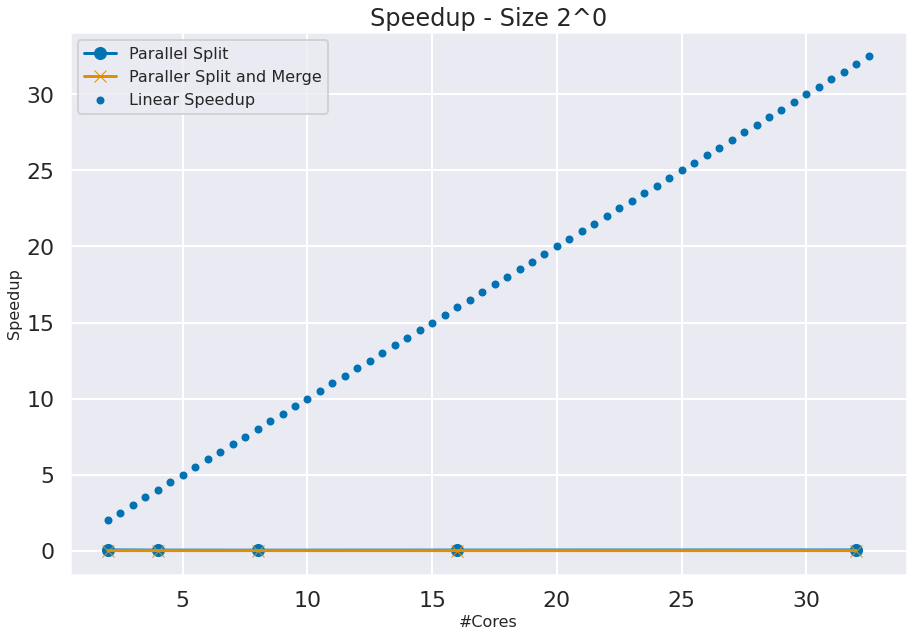

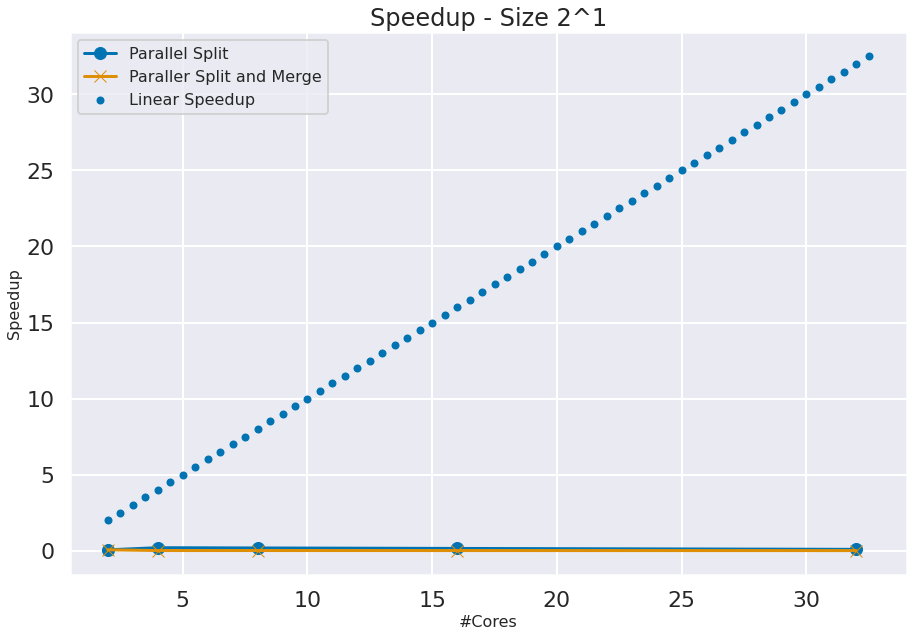

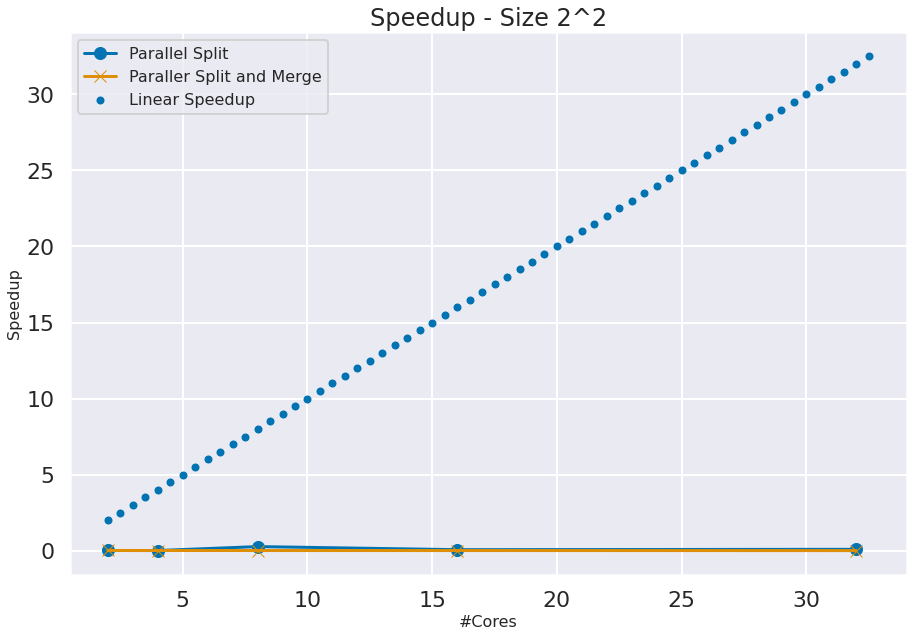

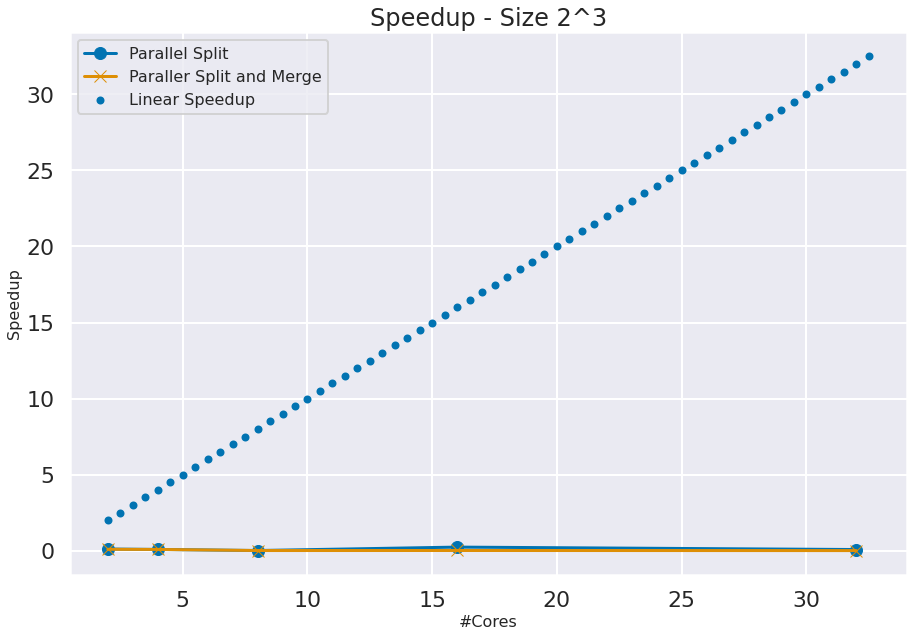

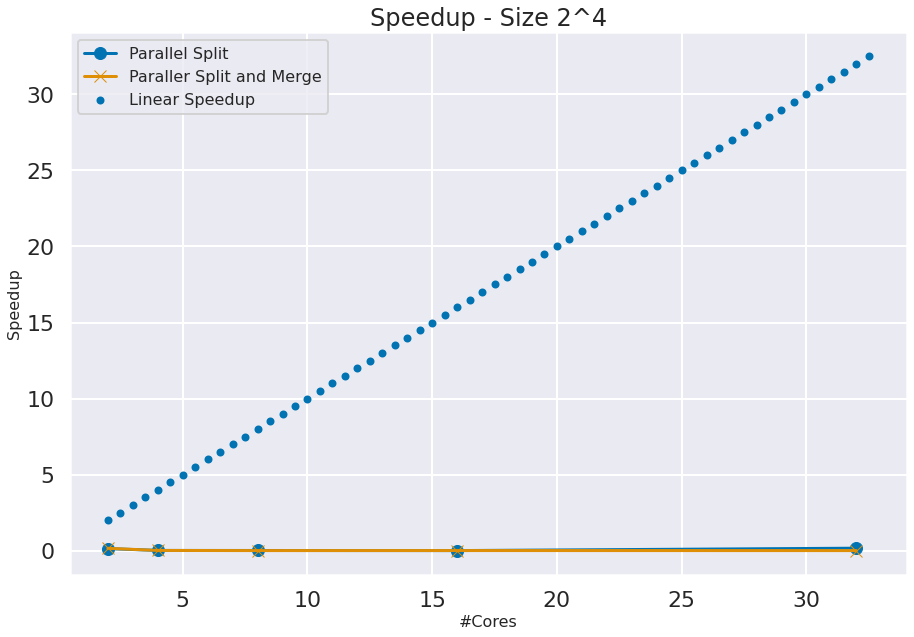

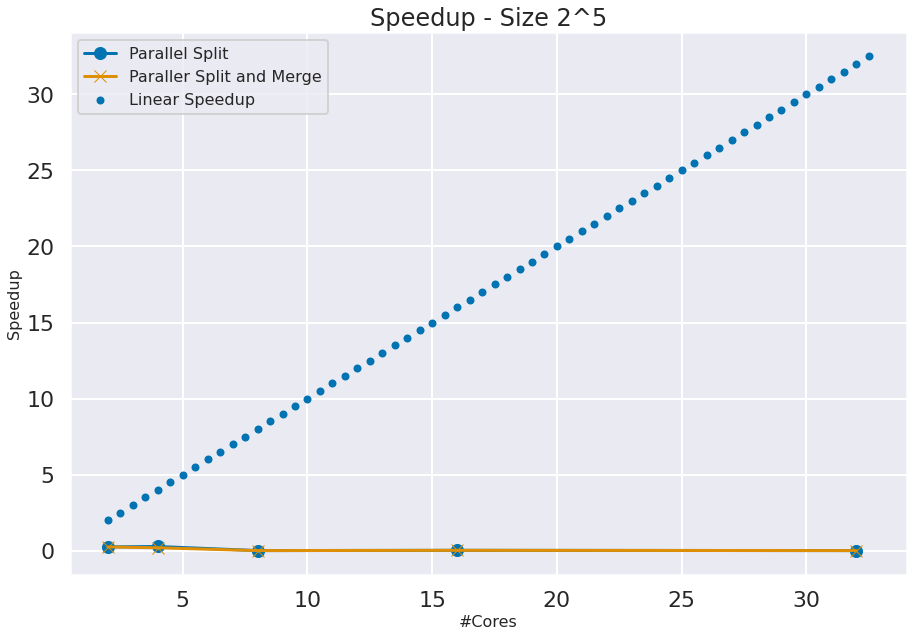

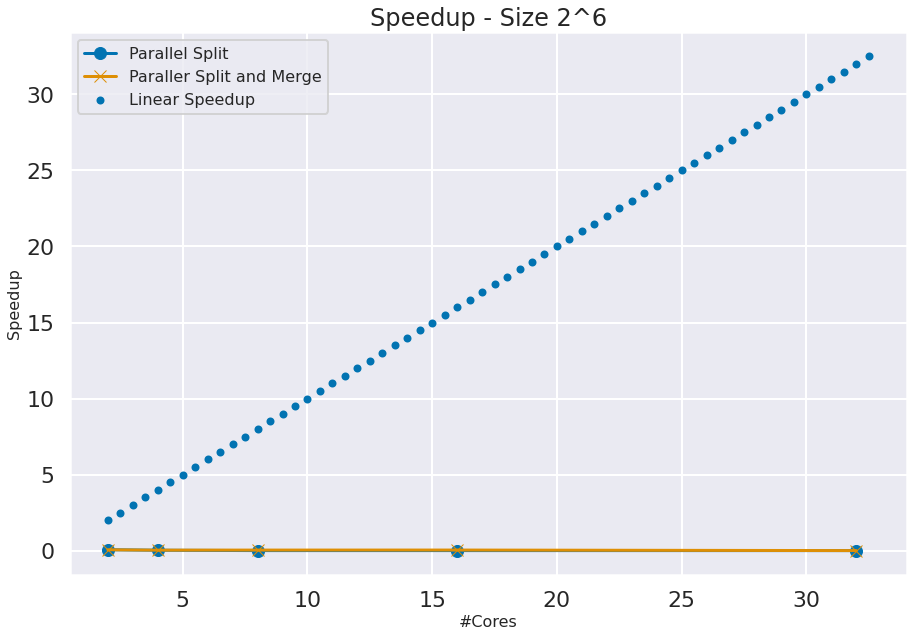

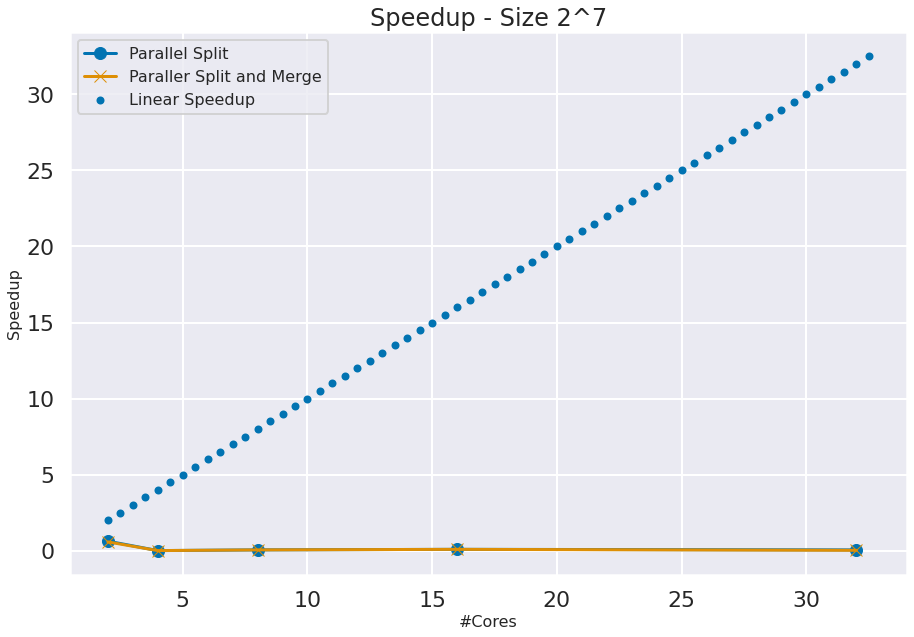

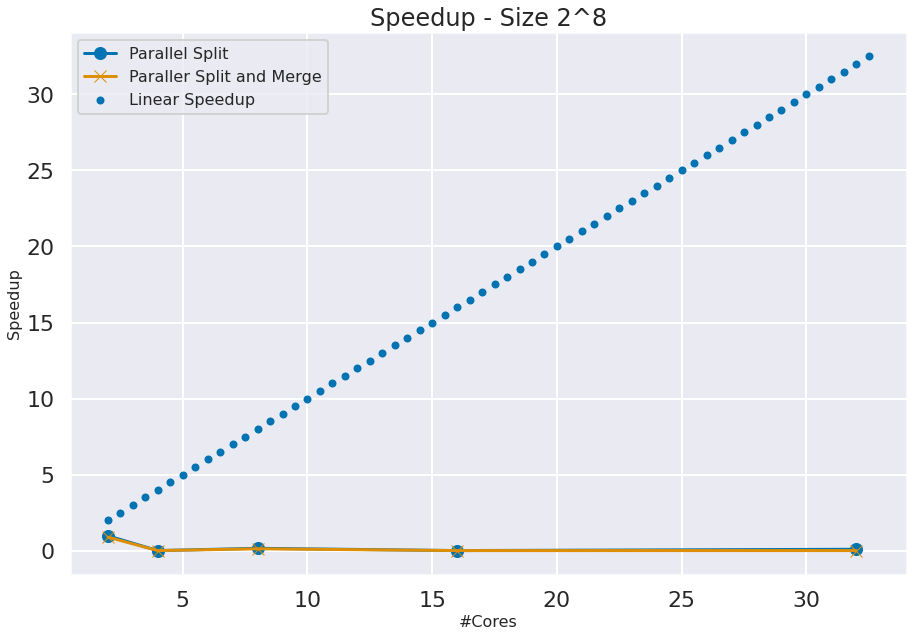

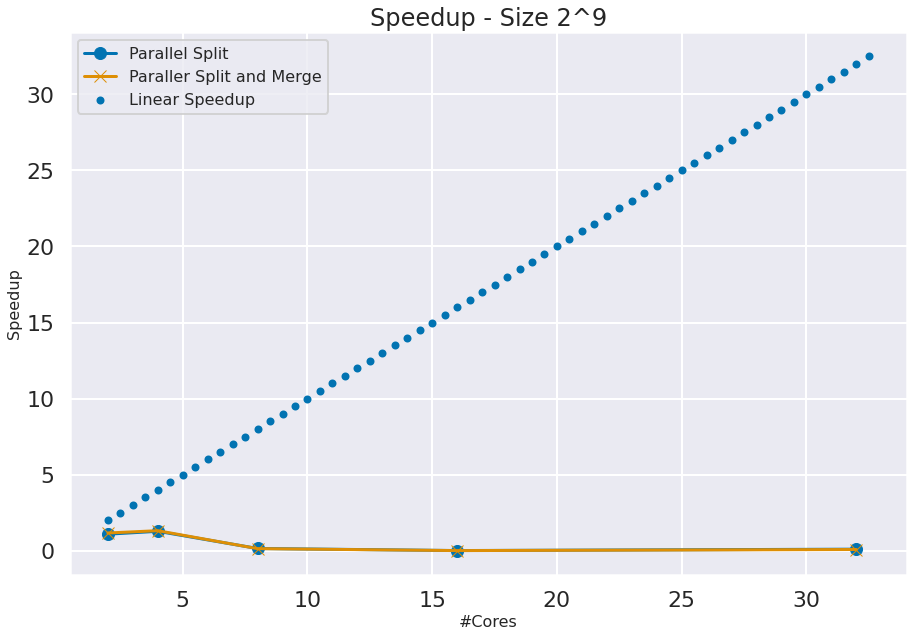

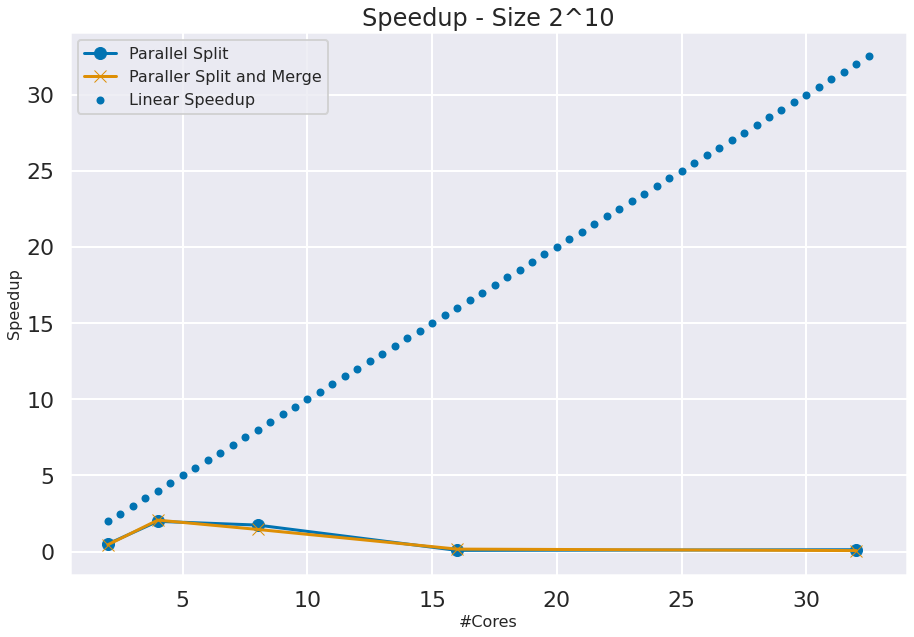

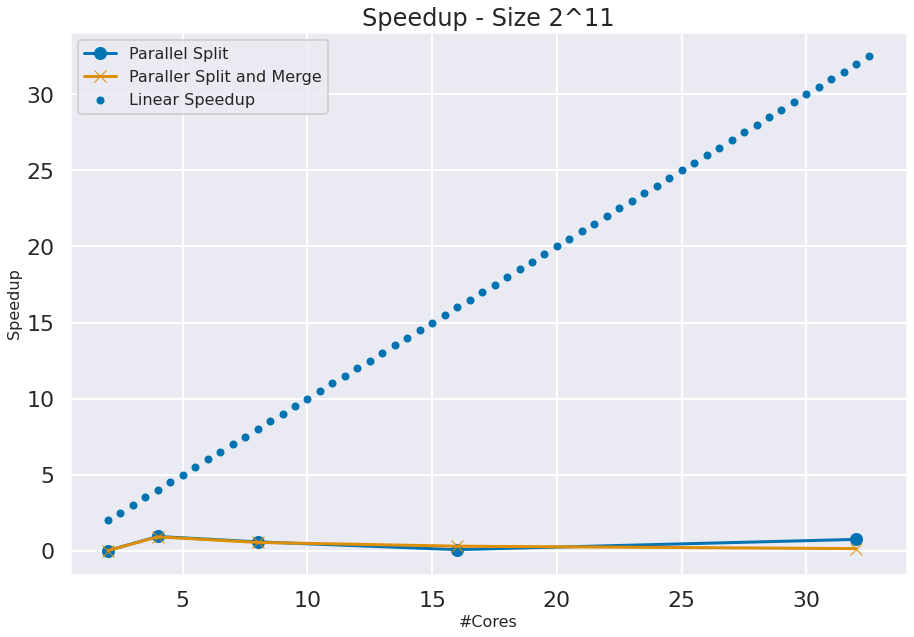

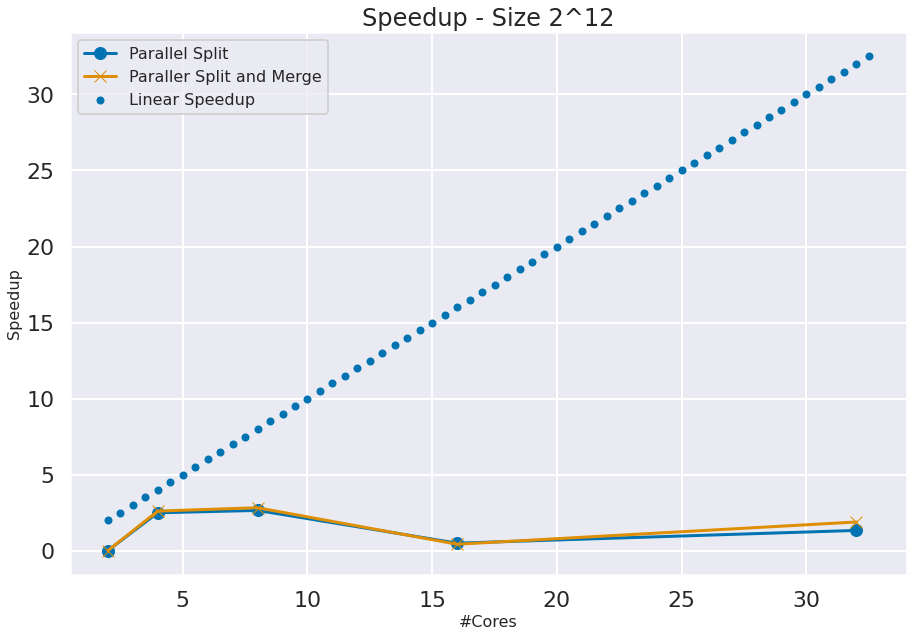

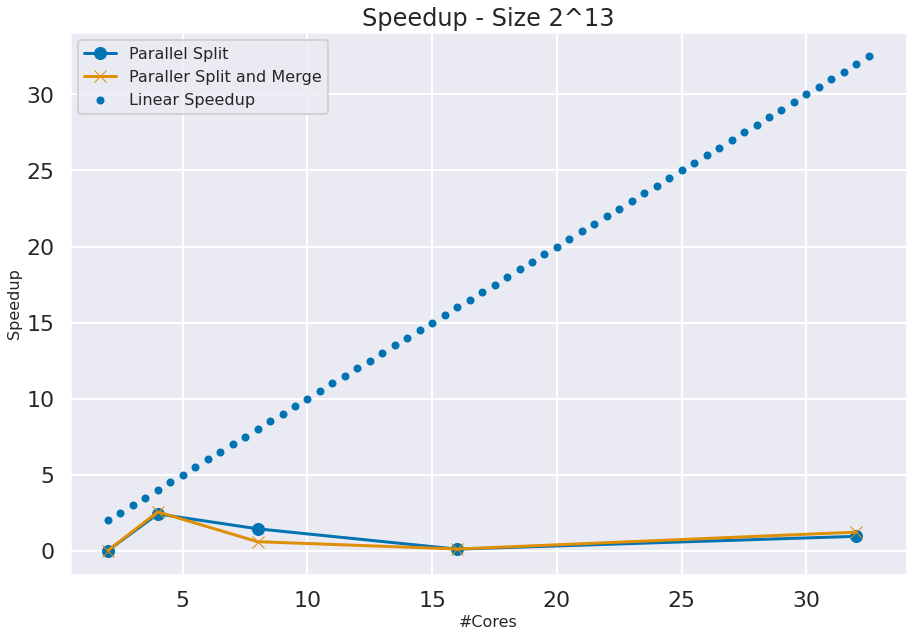

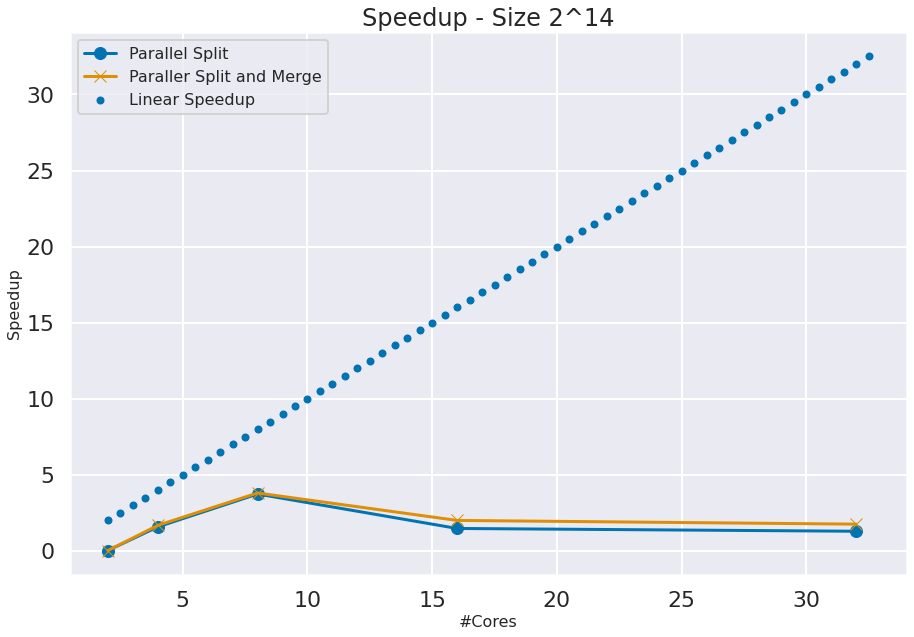

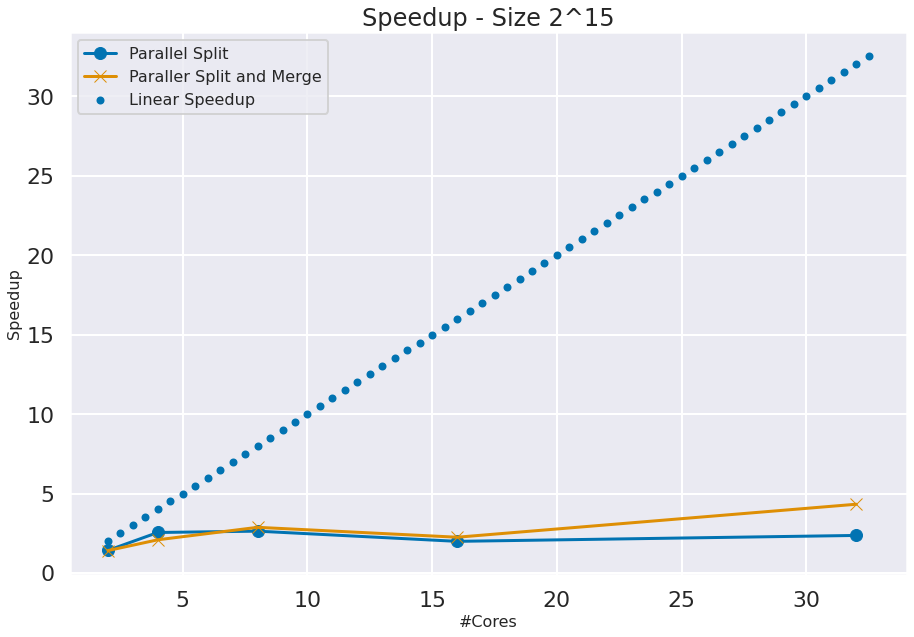

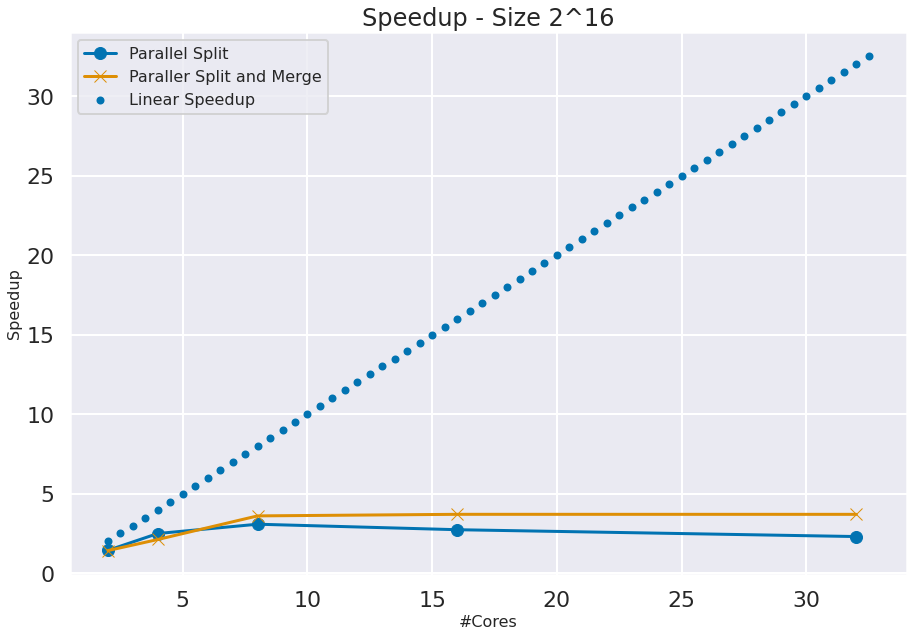

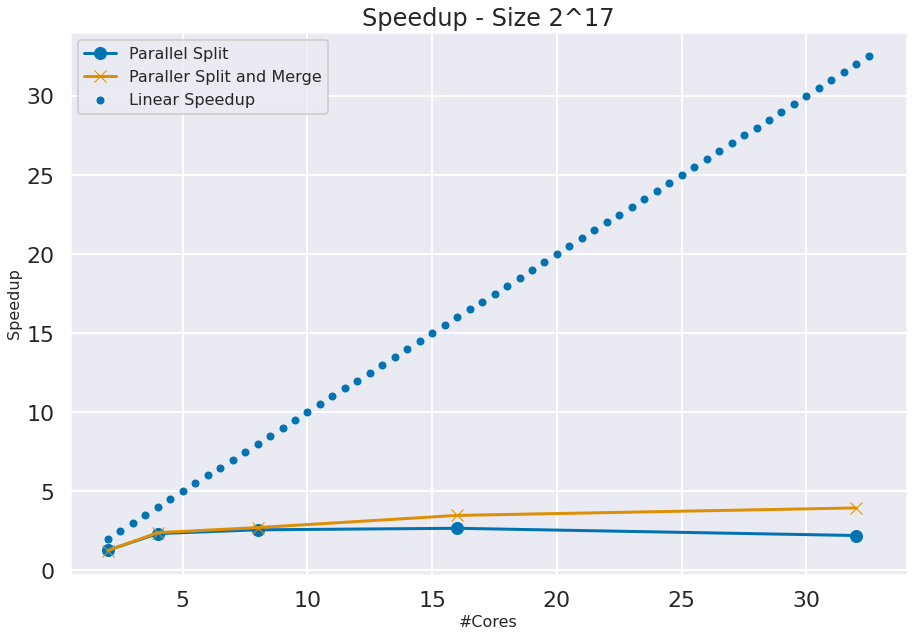

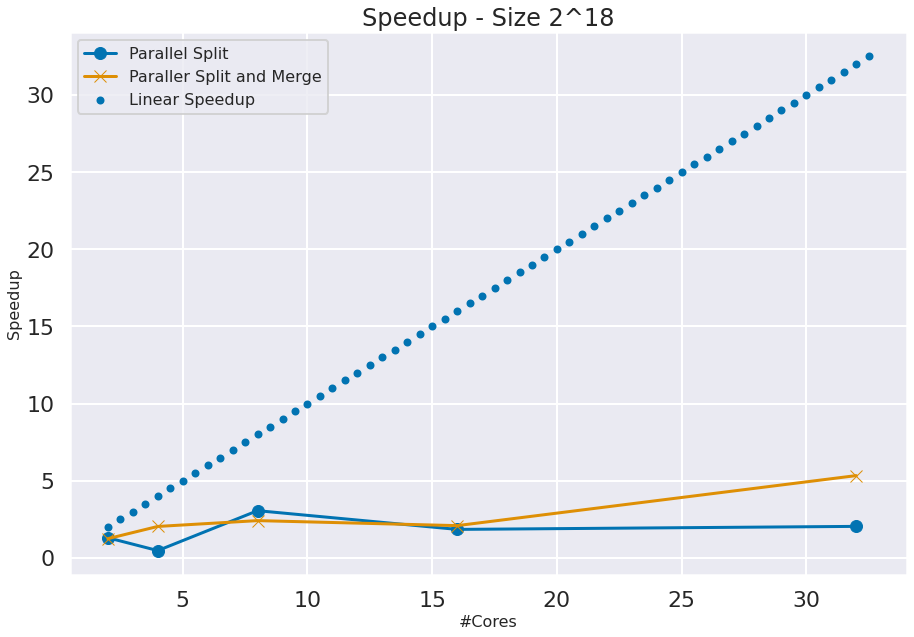

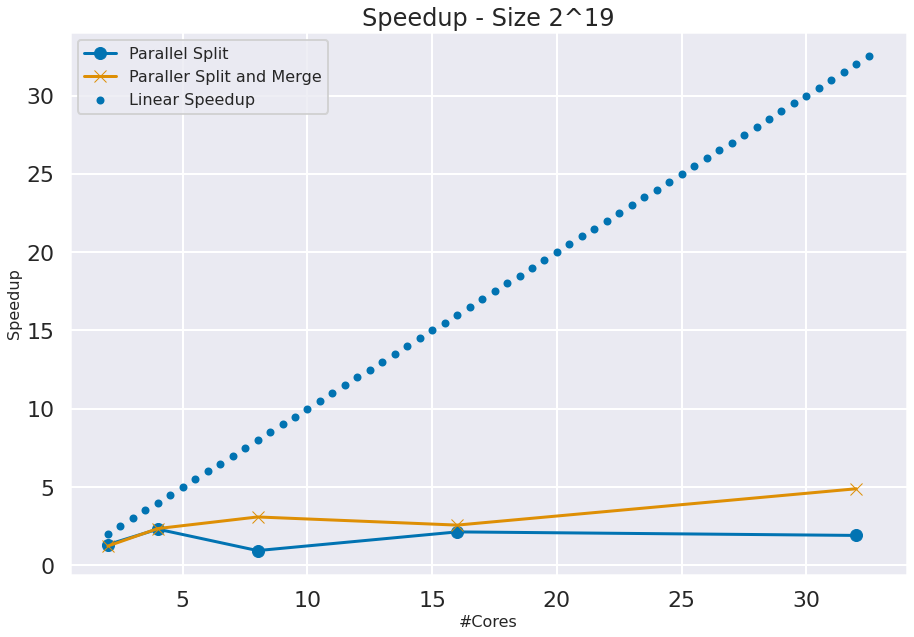

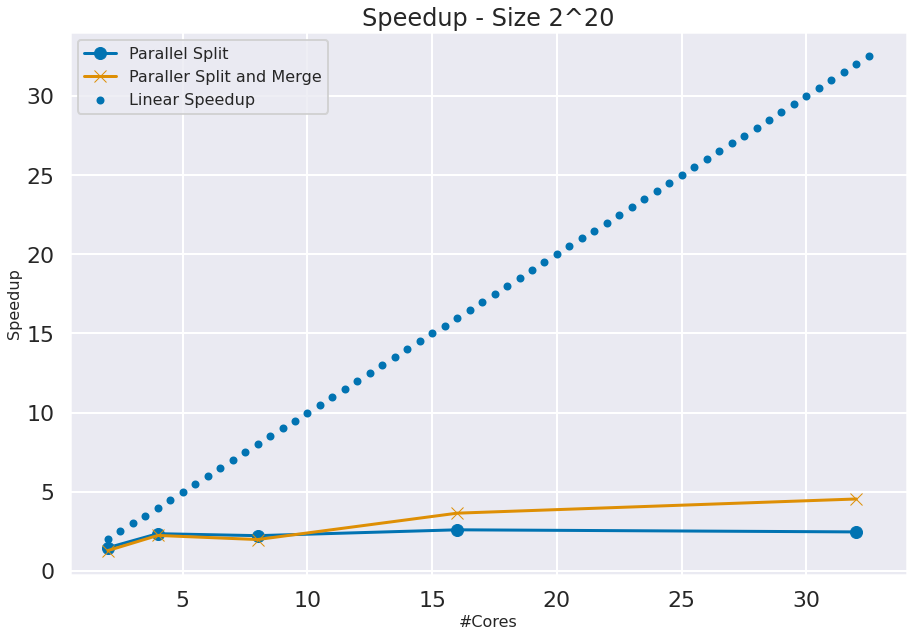

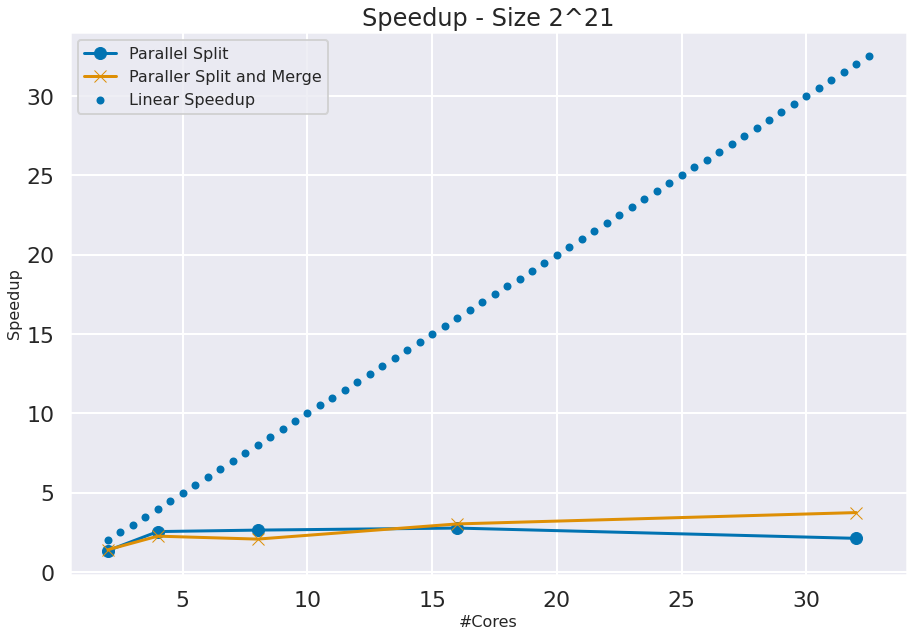

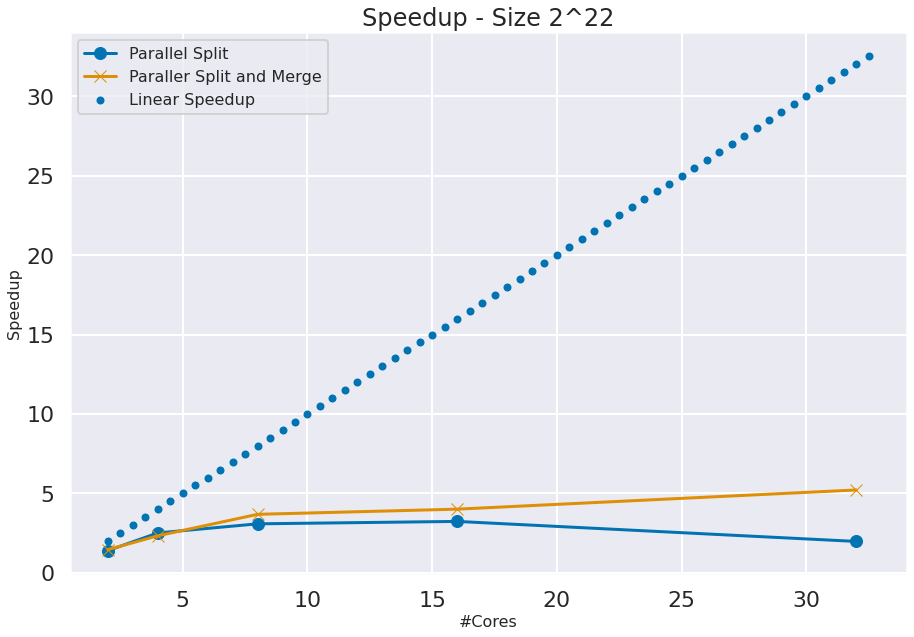

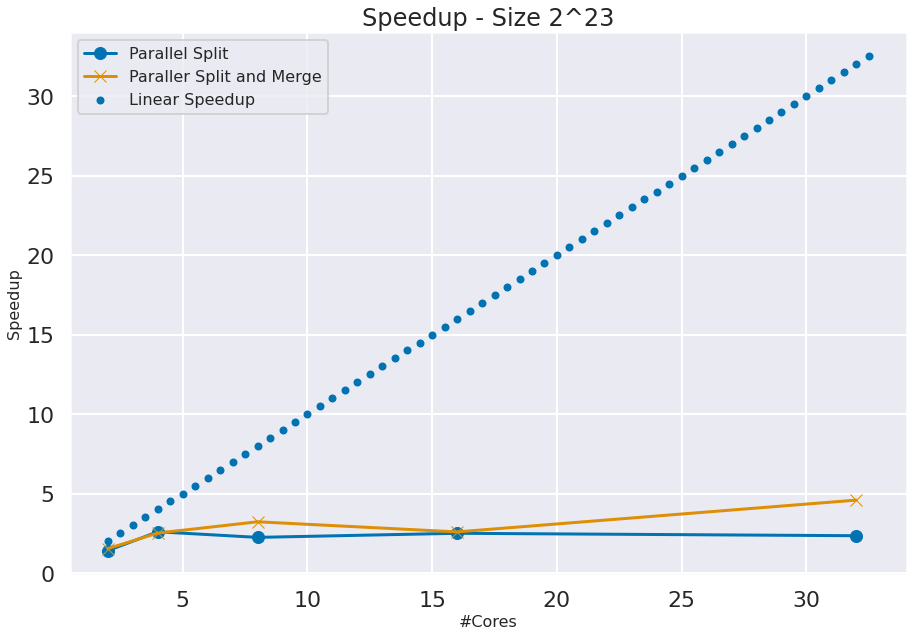

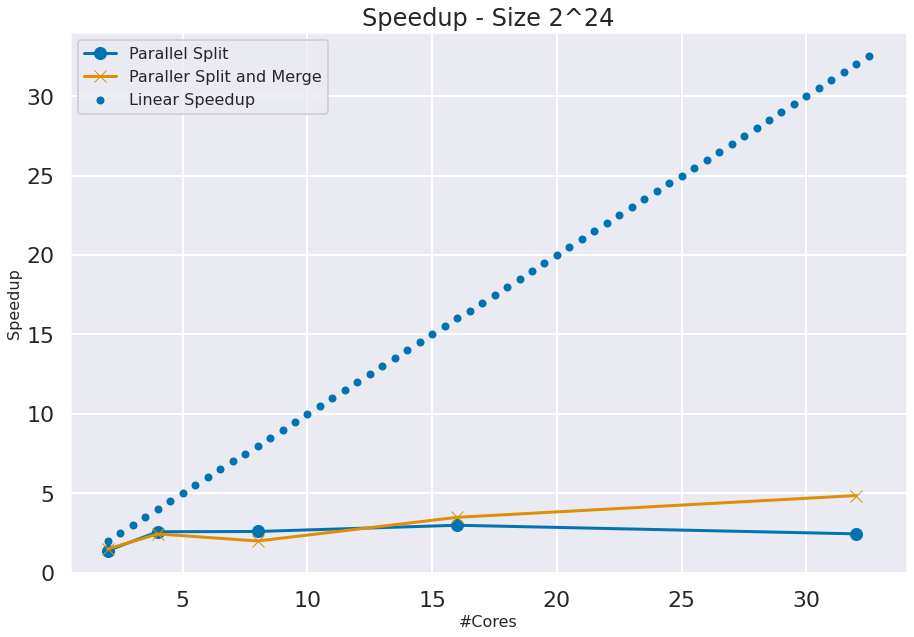

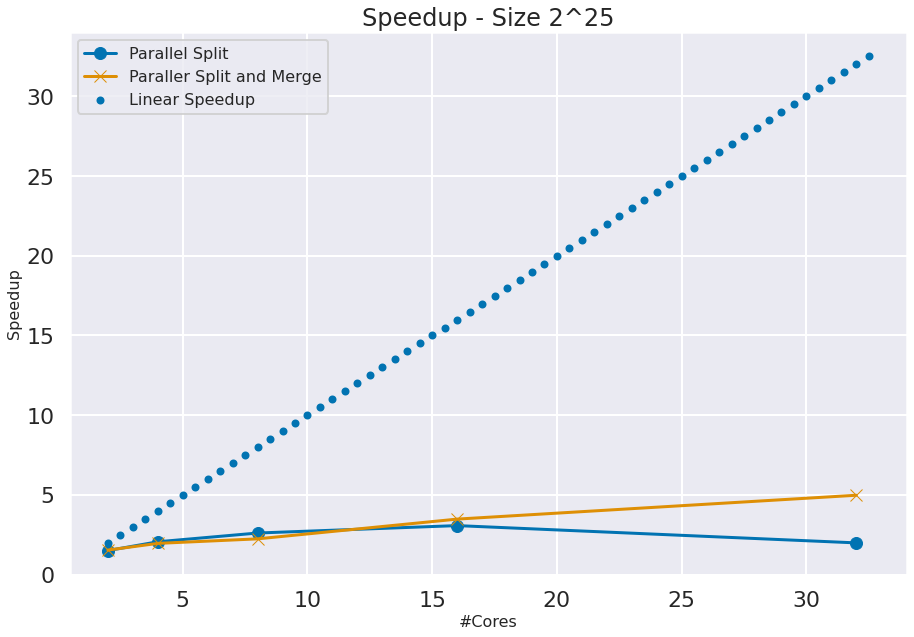

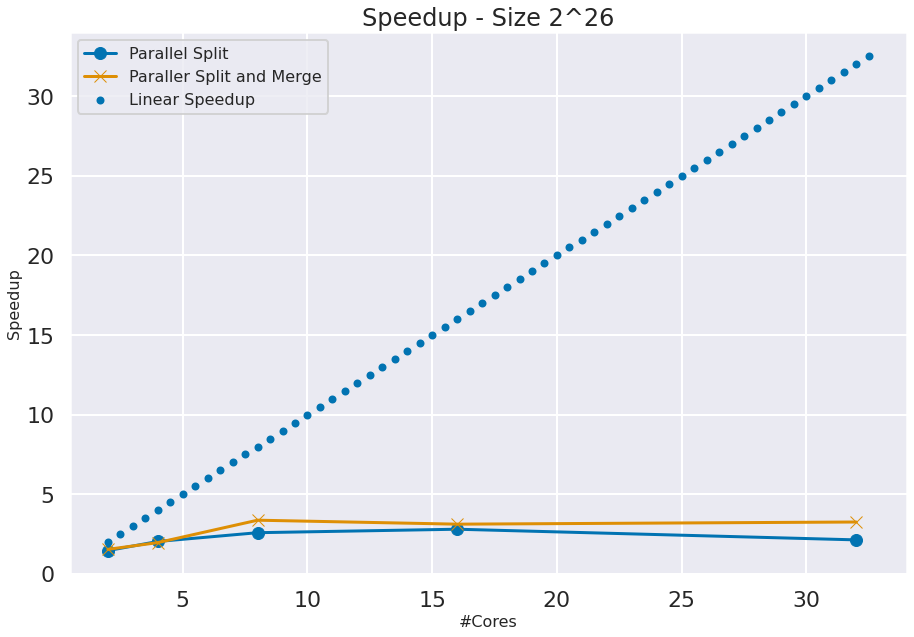

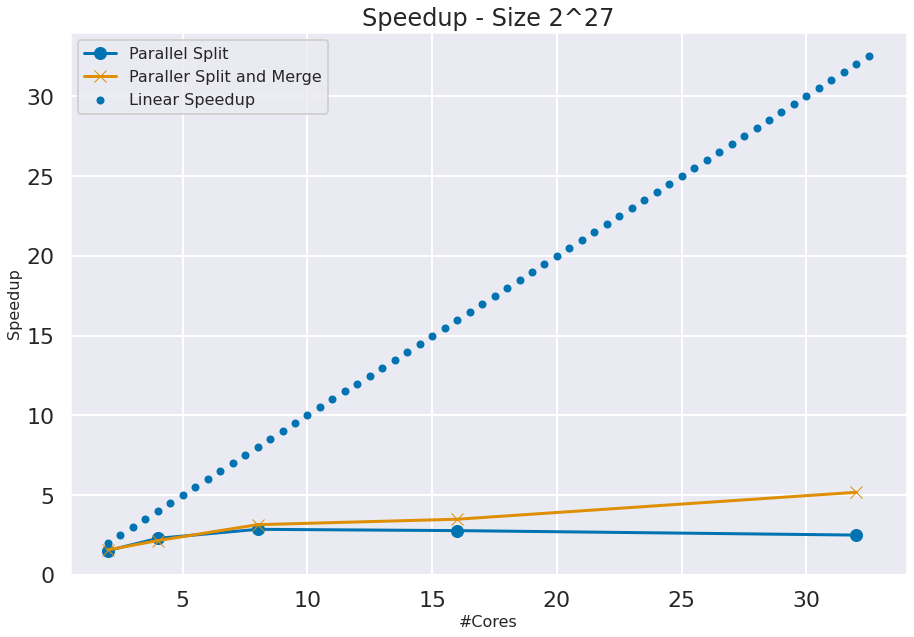

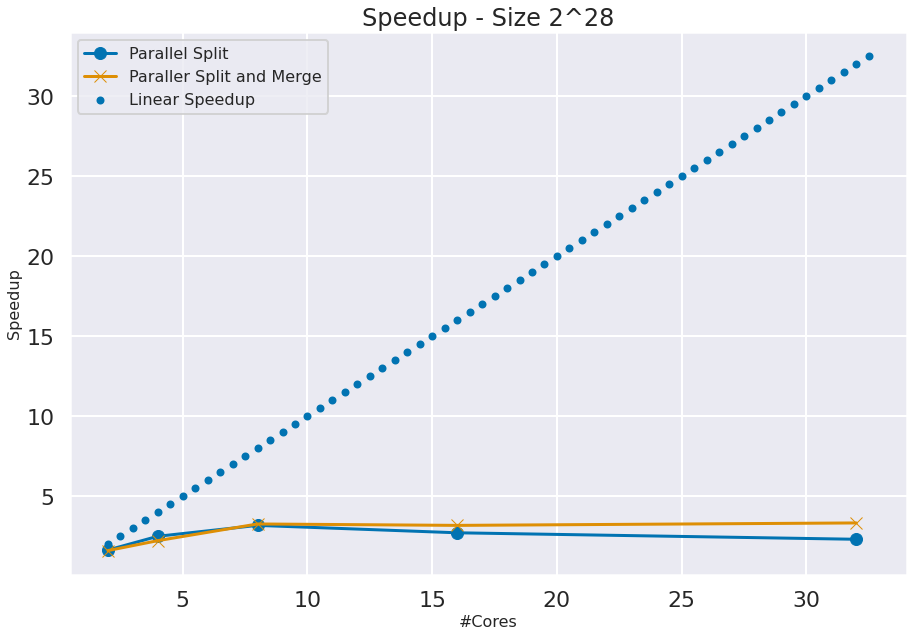

In [18]:
for i in range(29):
    plot_speedup(i)

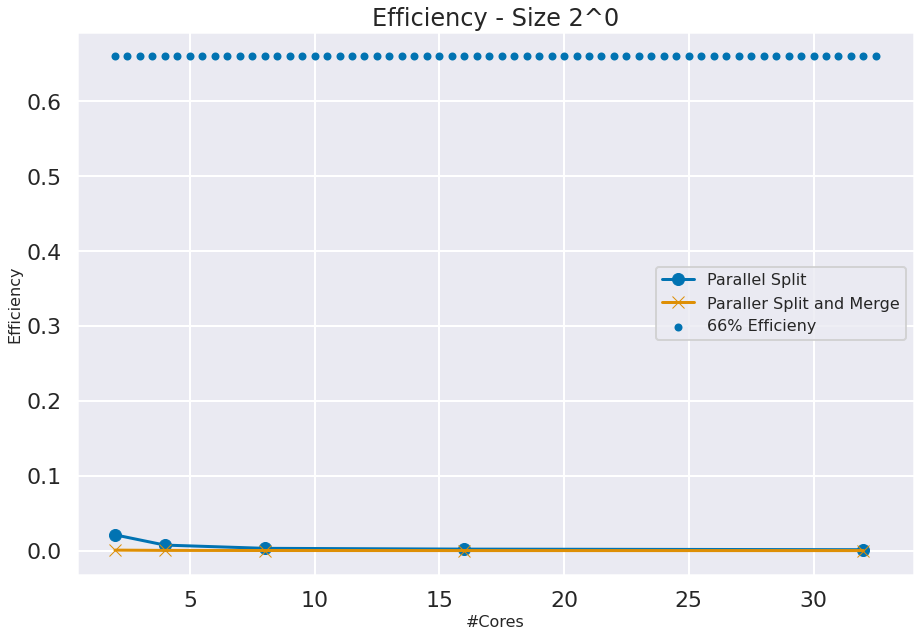

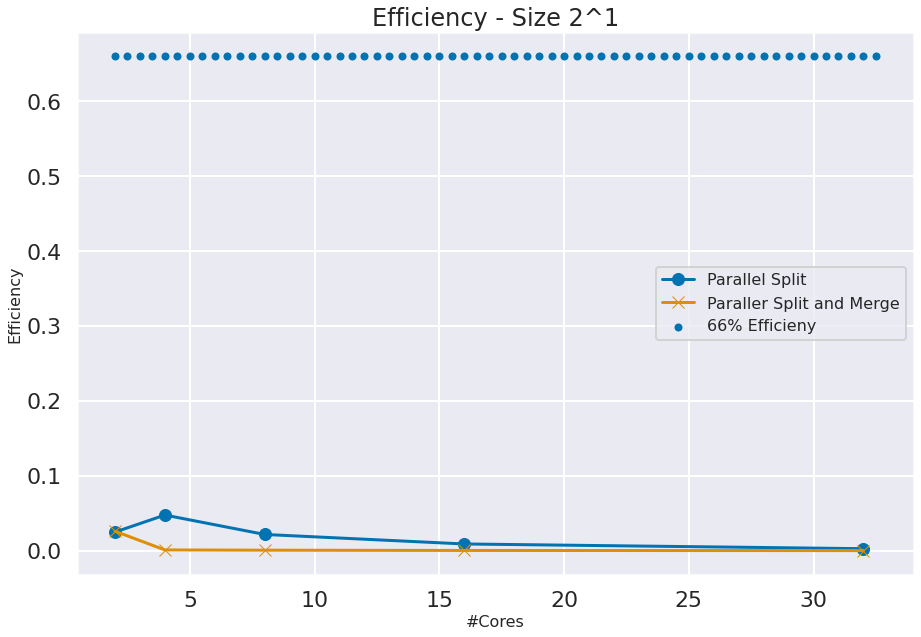

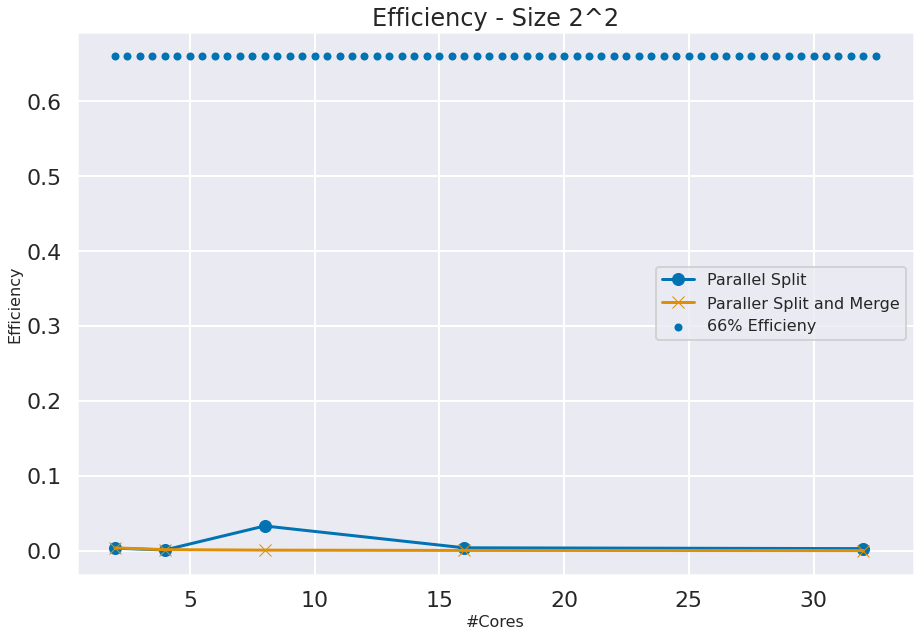

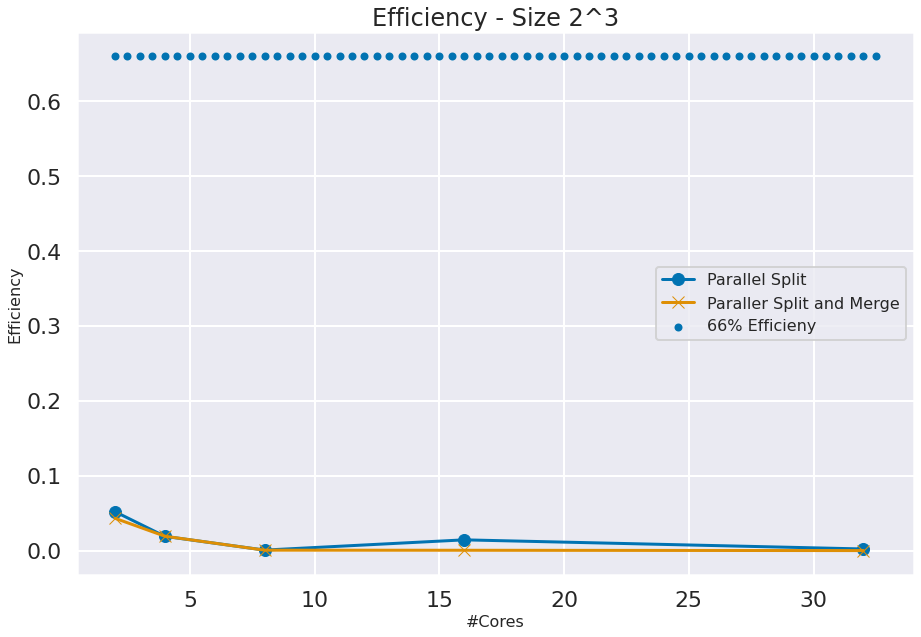

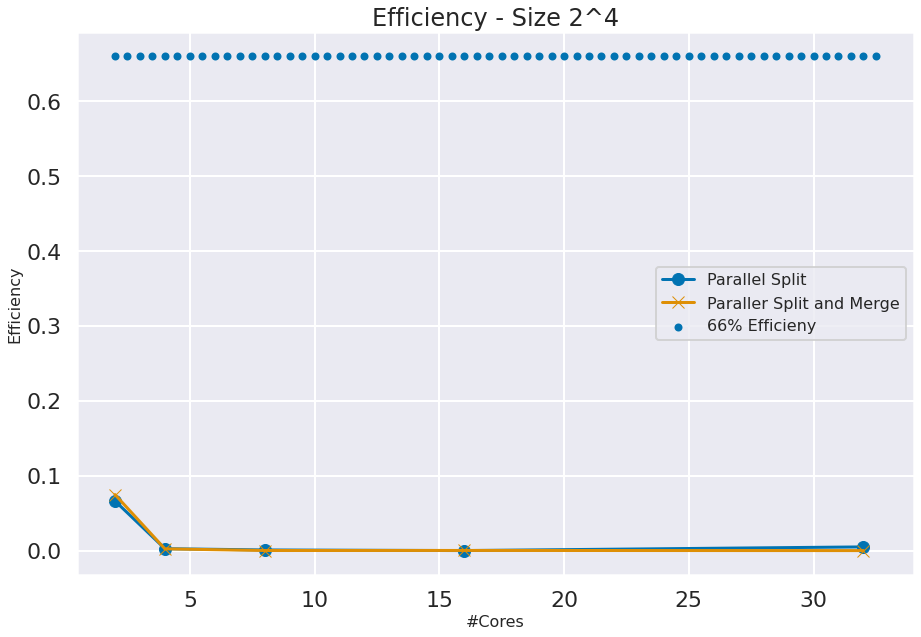

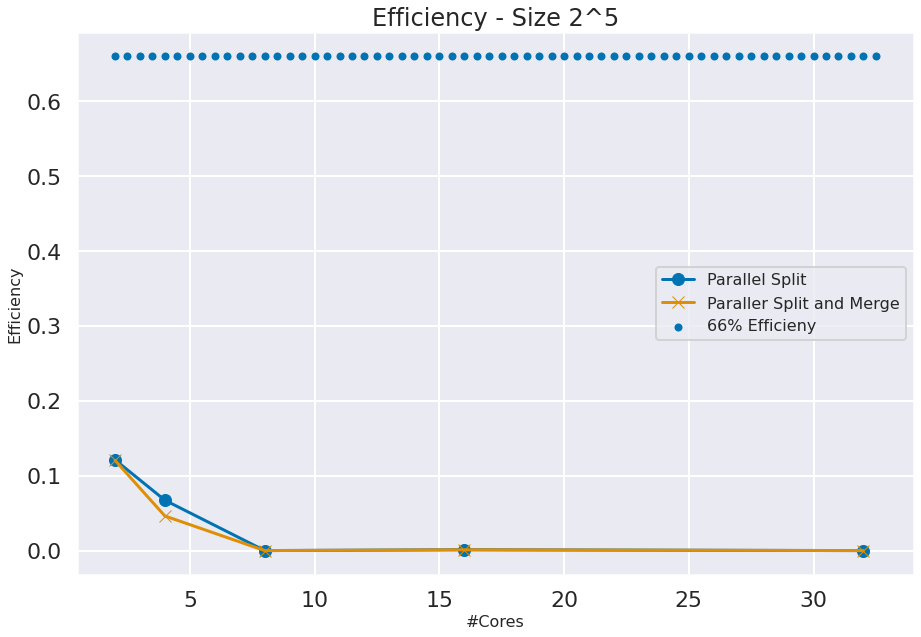

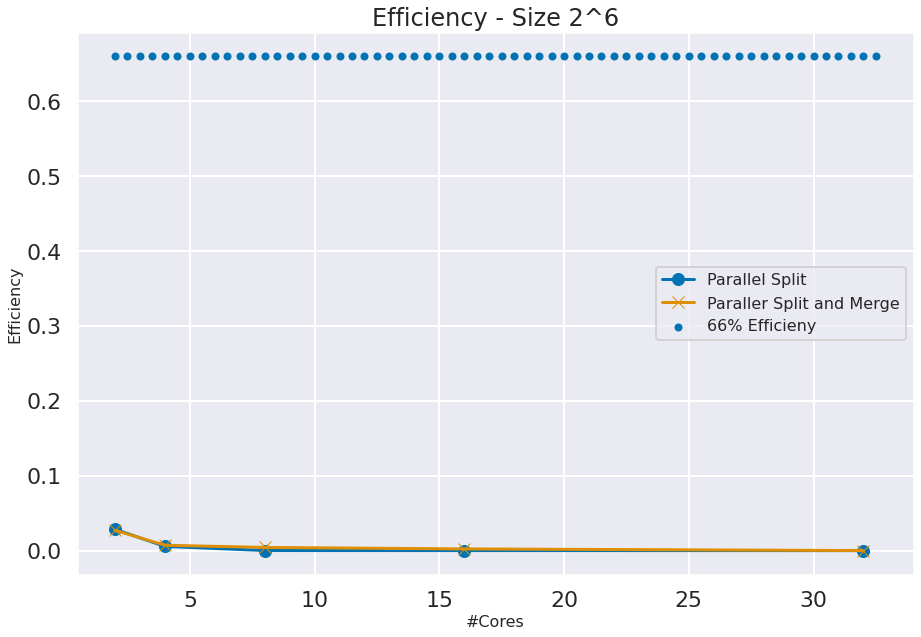

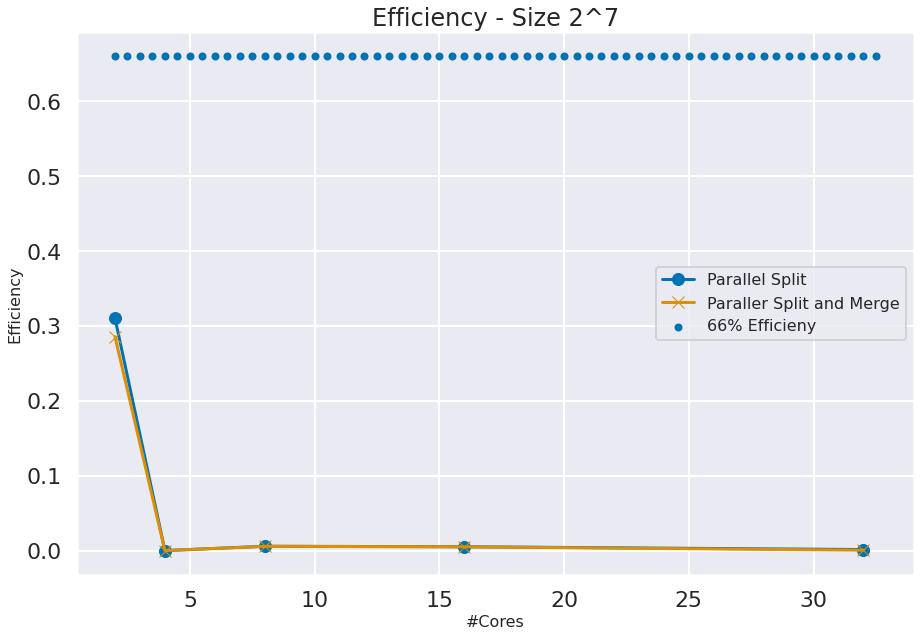

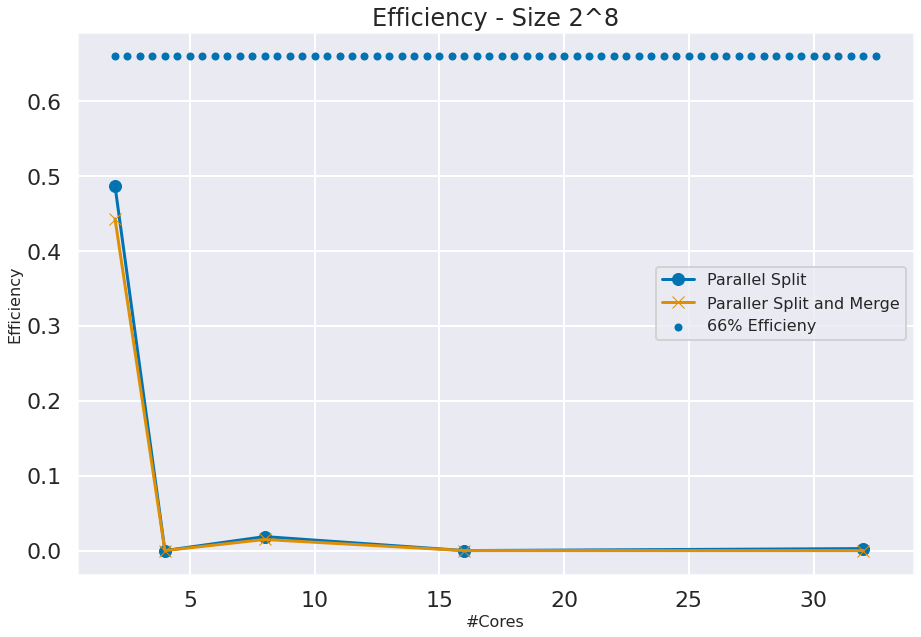

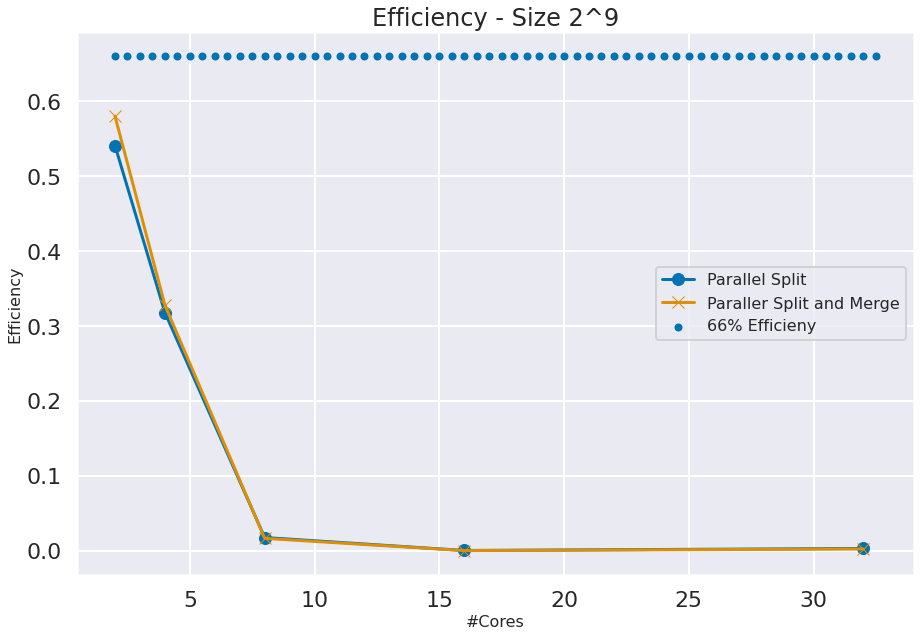

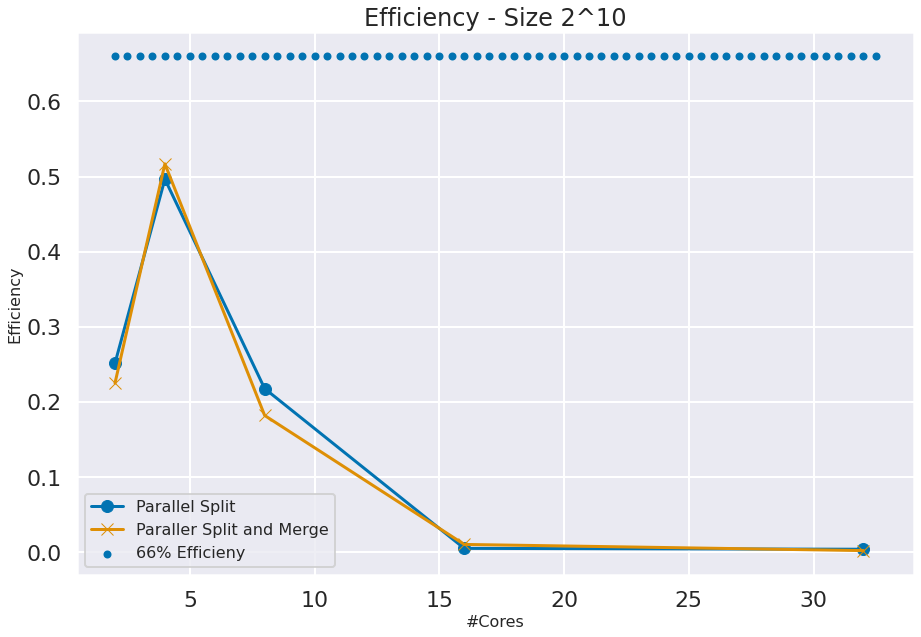

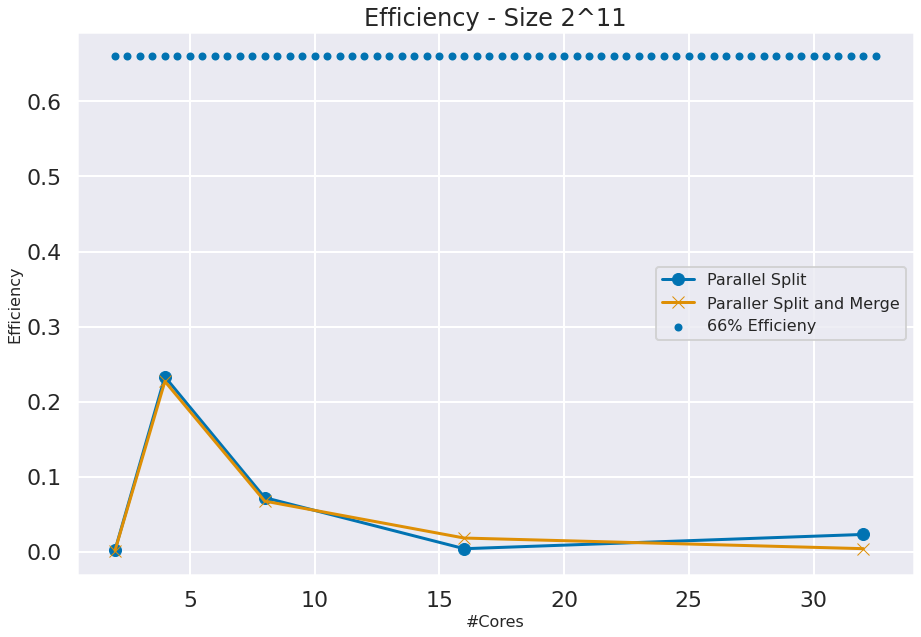

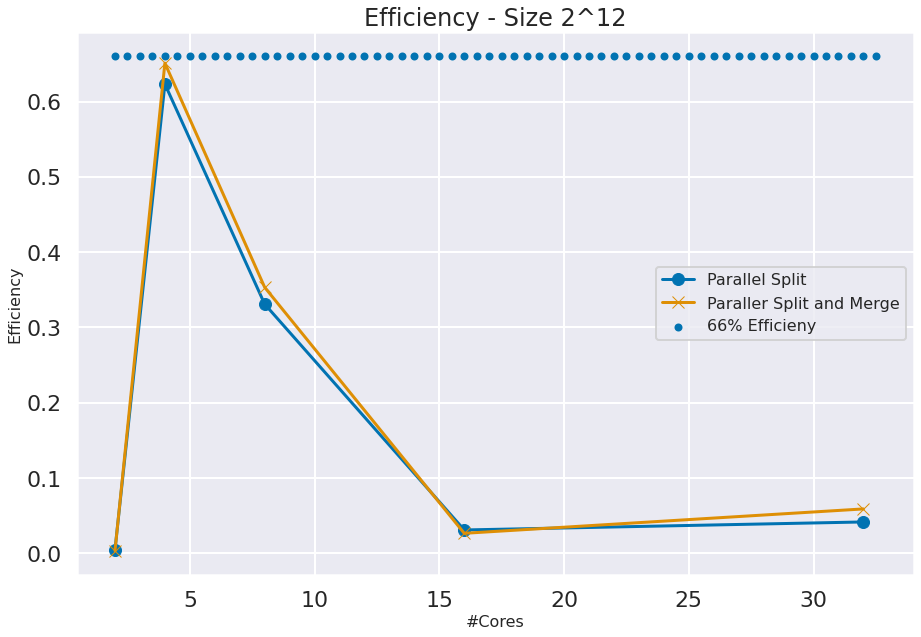

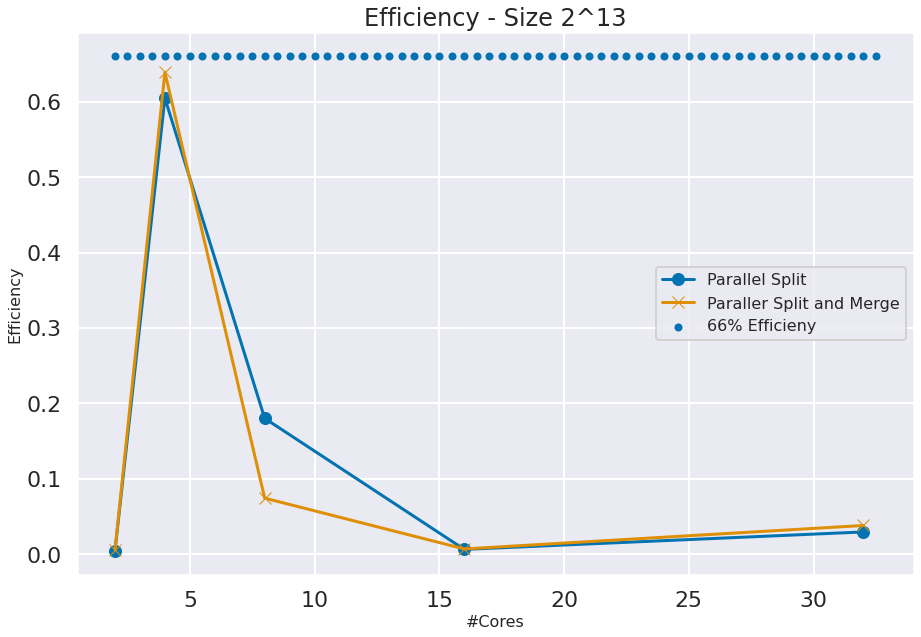

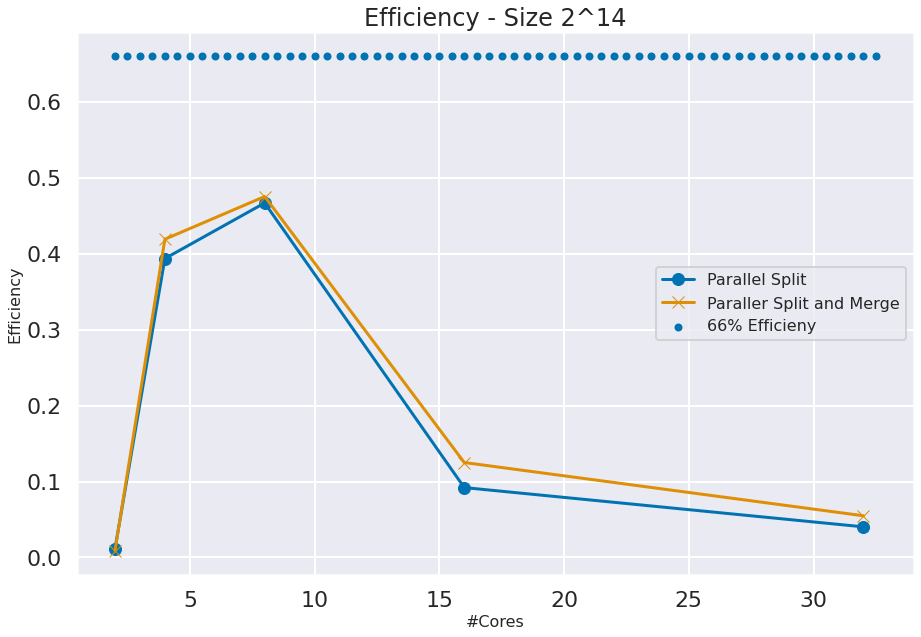

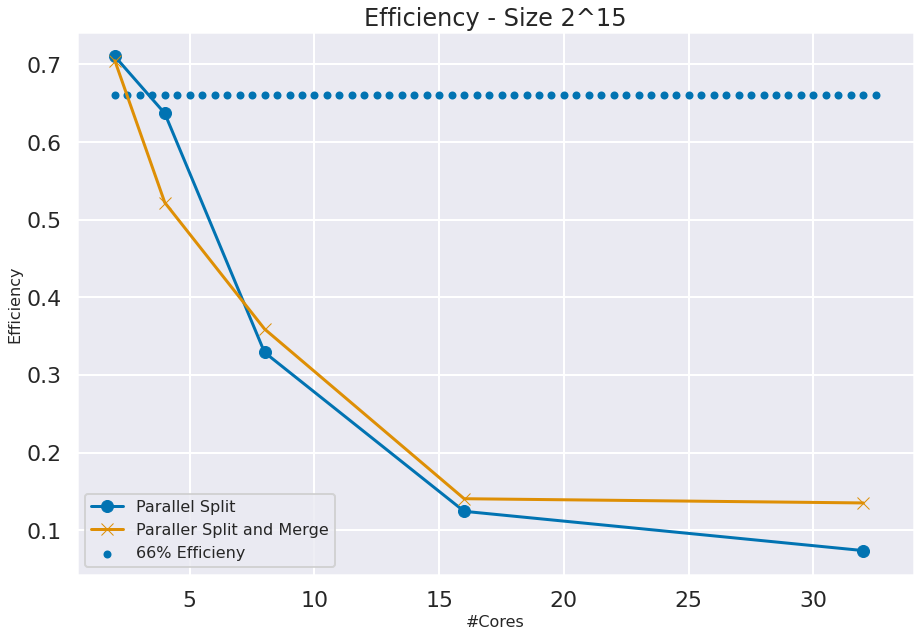

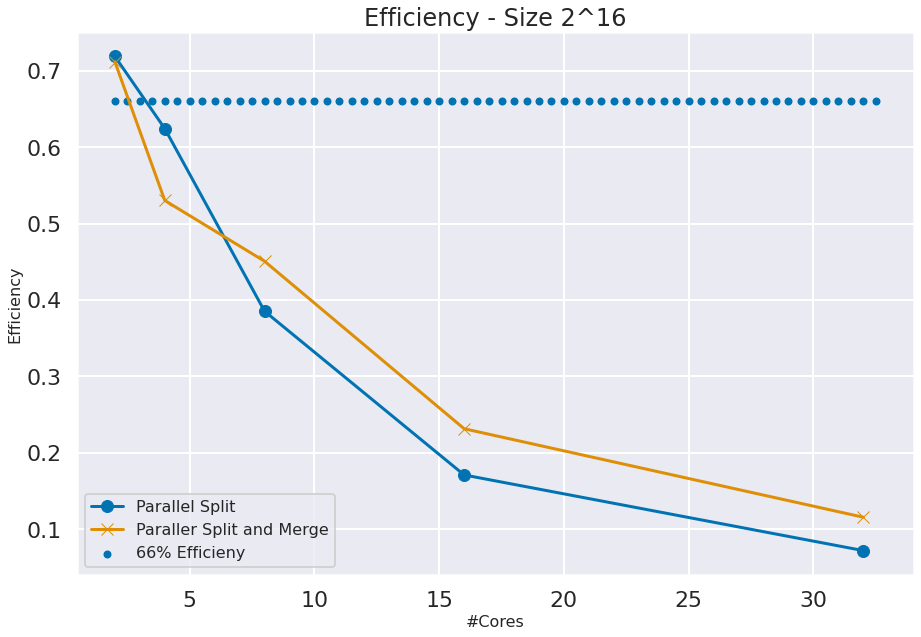

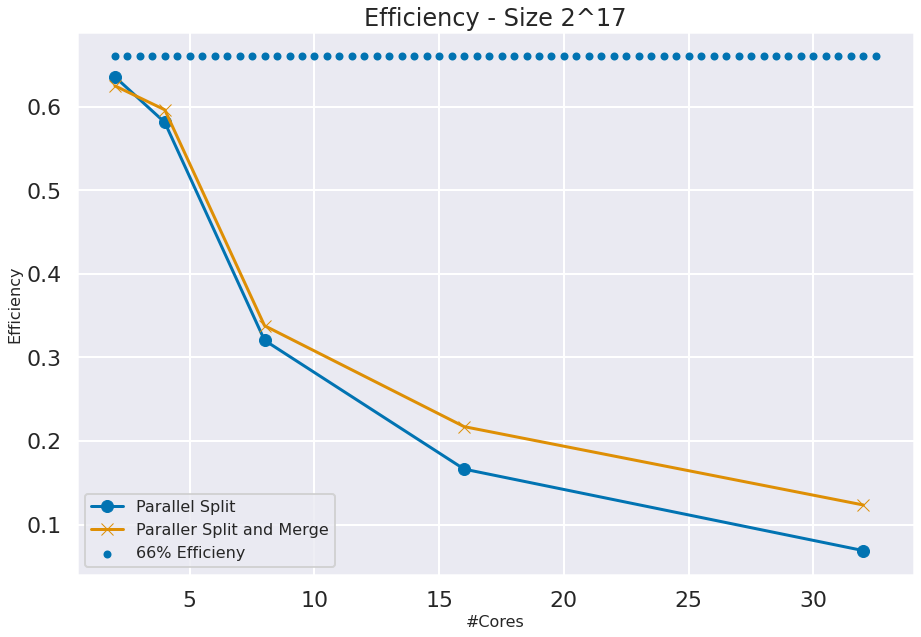

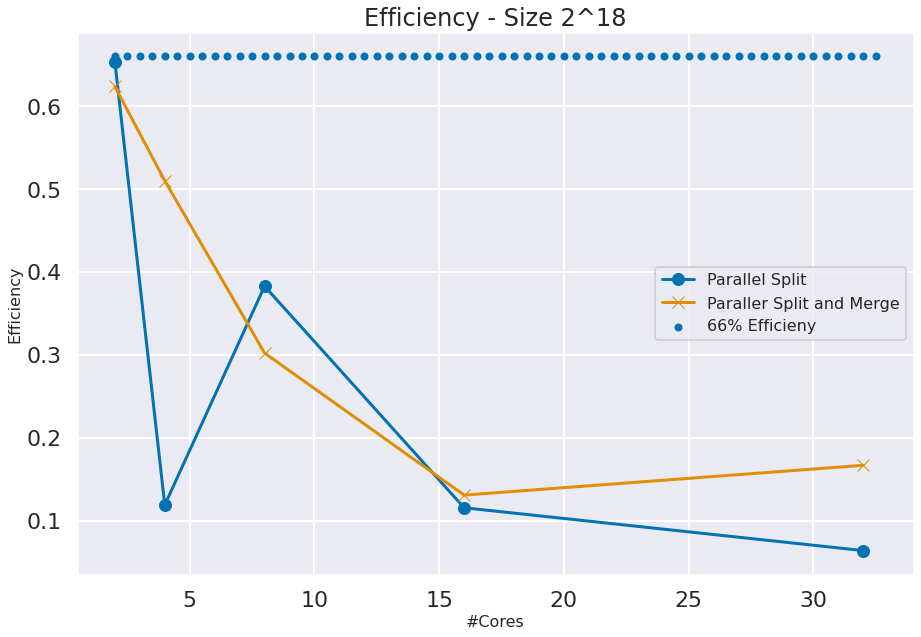

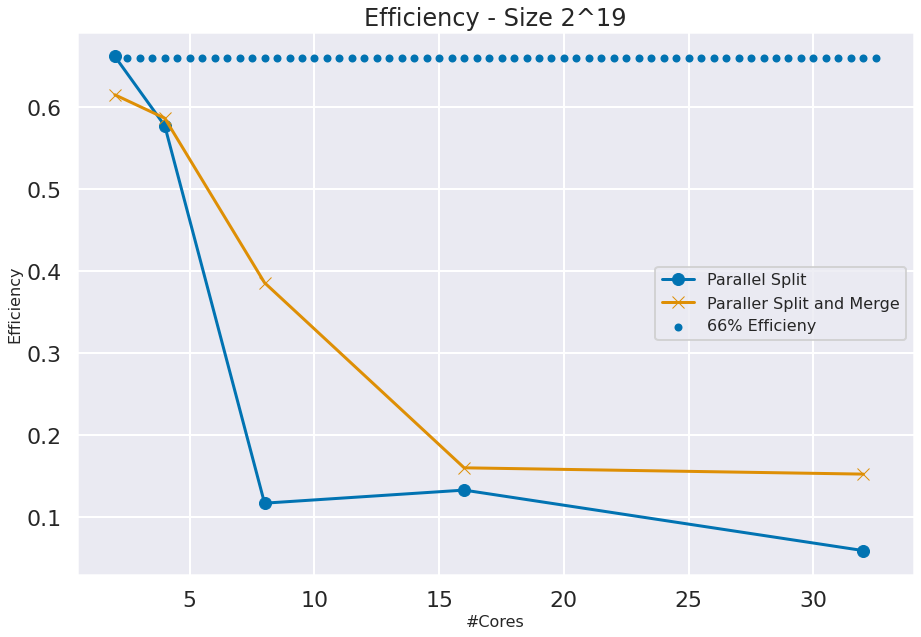

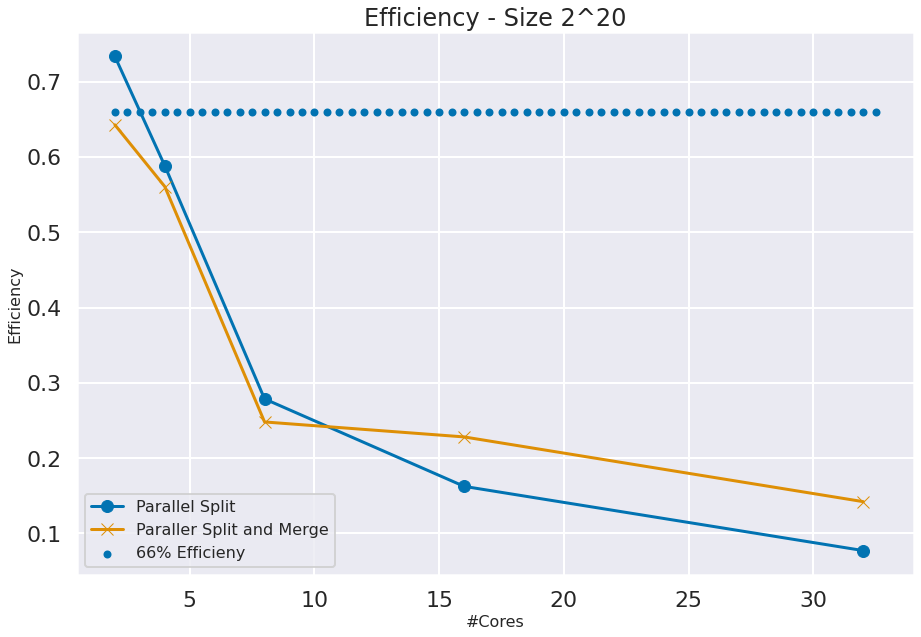

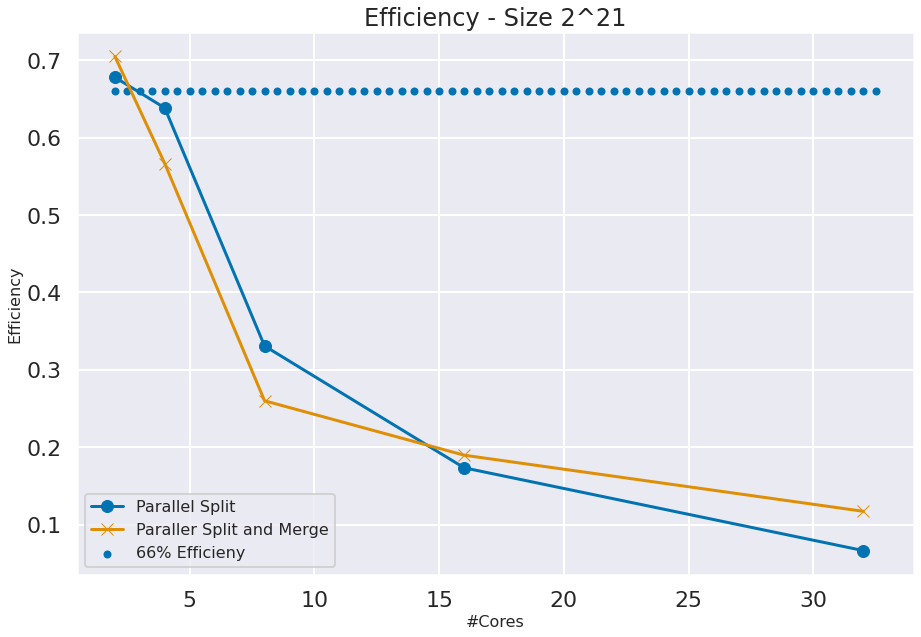

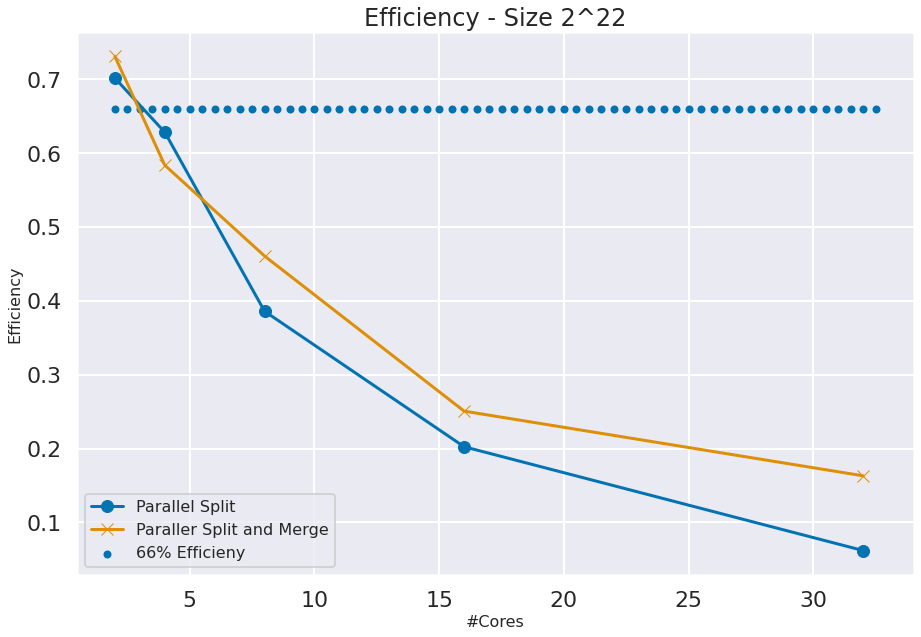

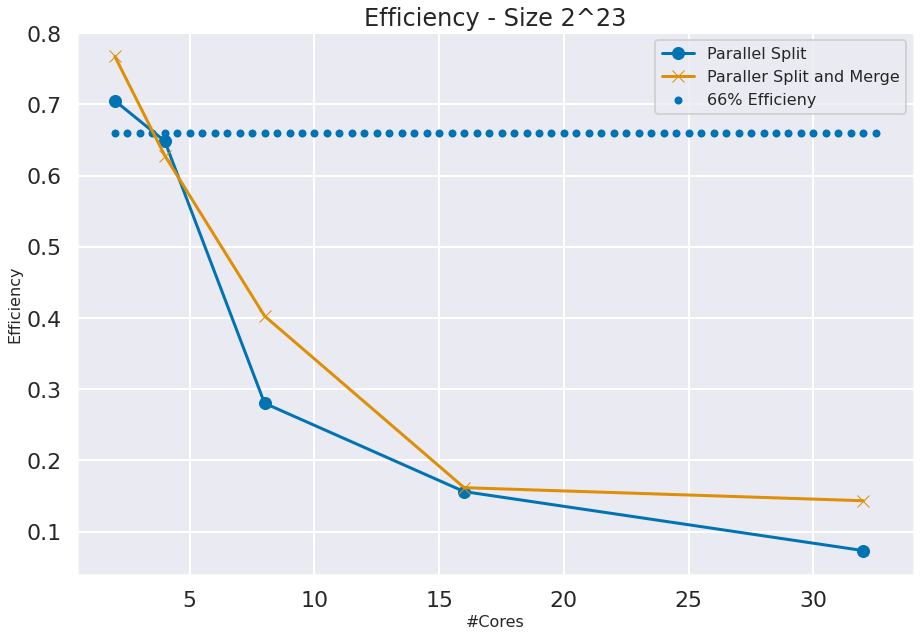

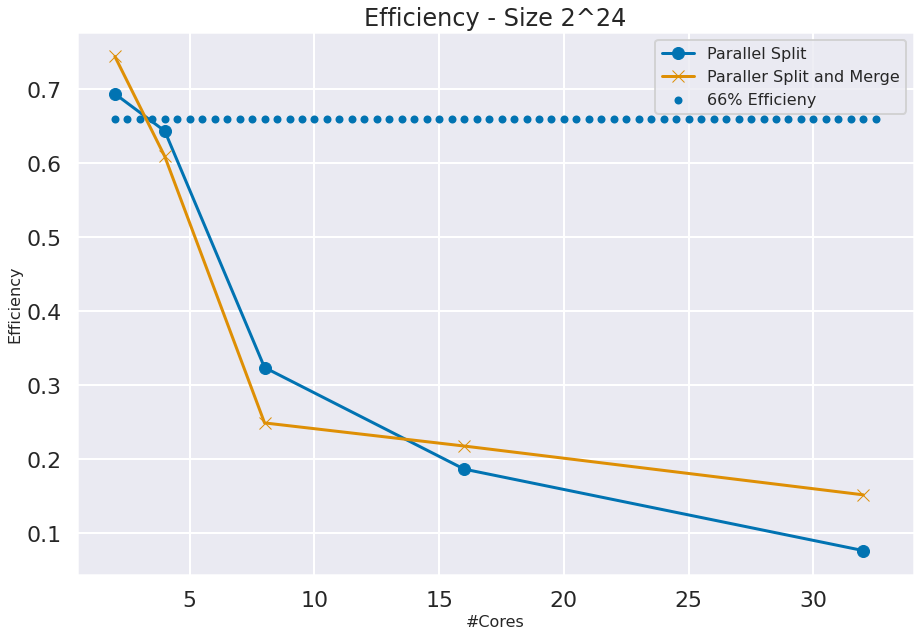

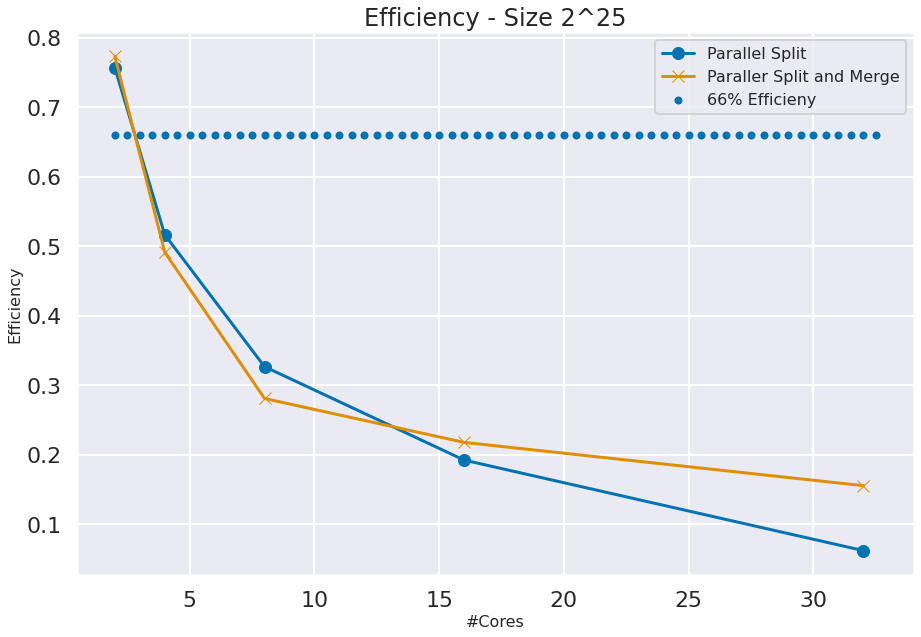

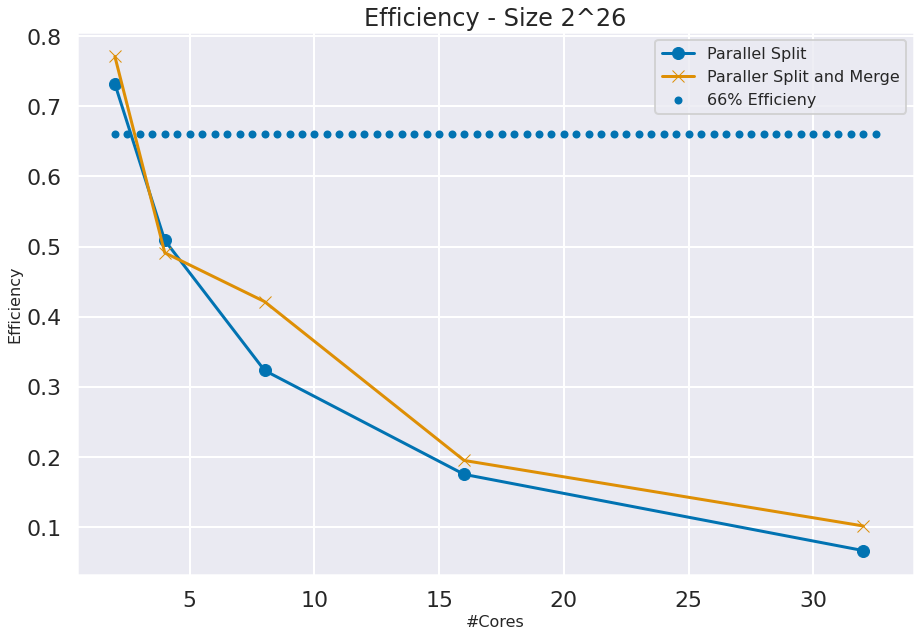

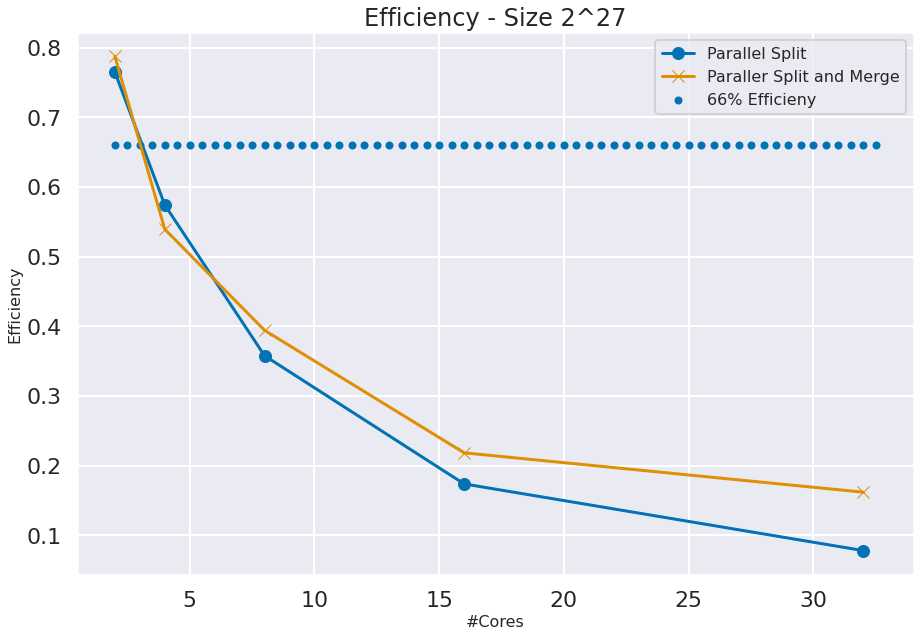

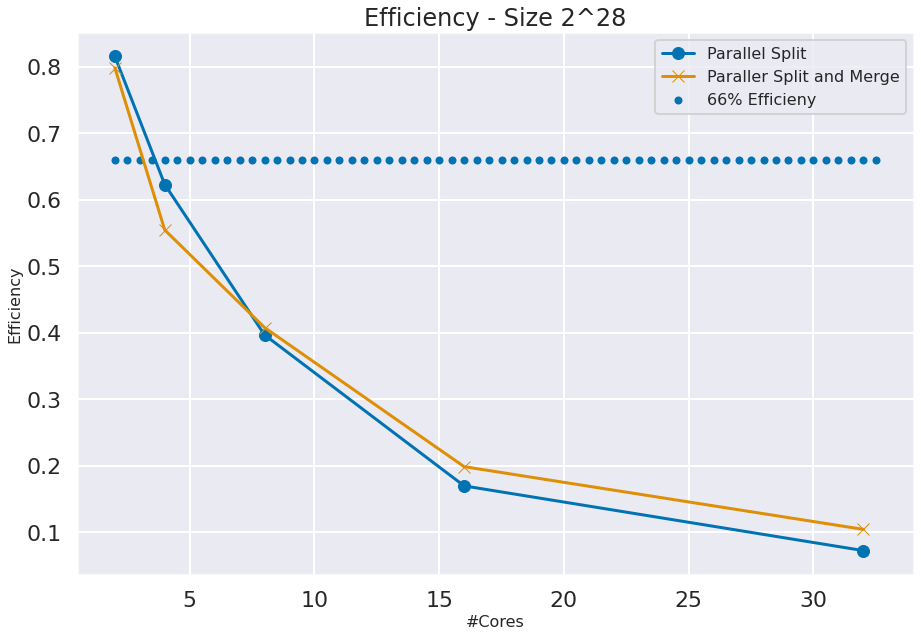

In [13]:
for i in range(29):    
    plot_efficiency(i)

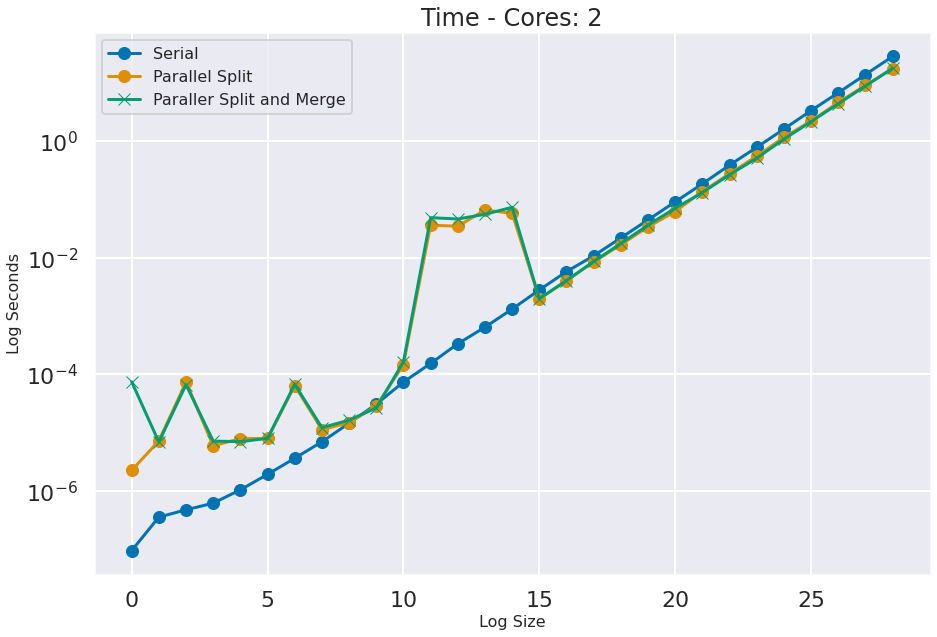

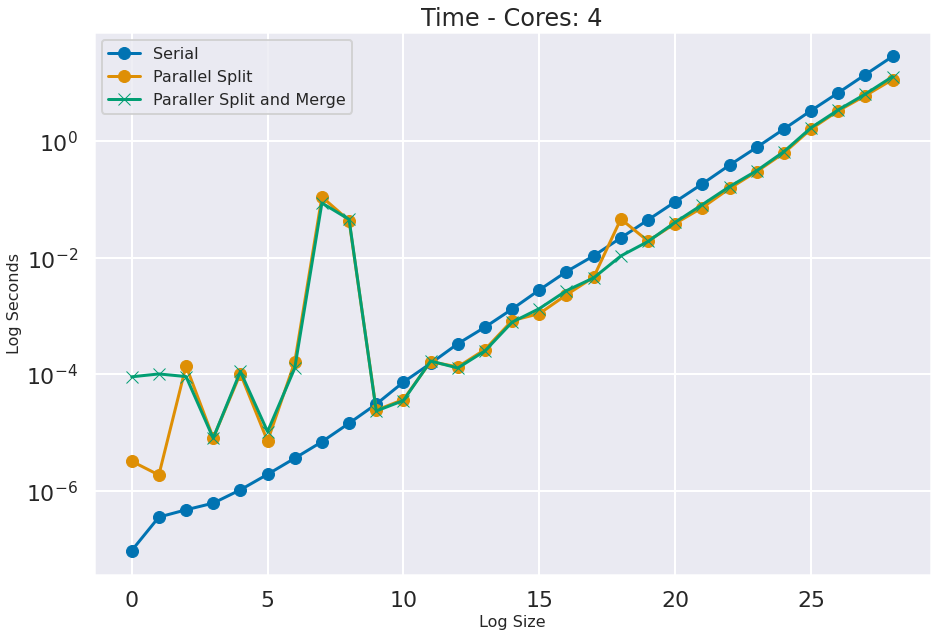

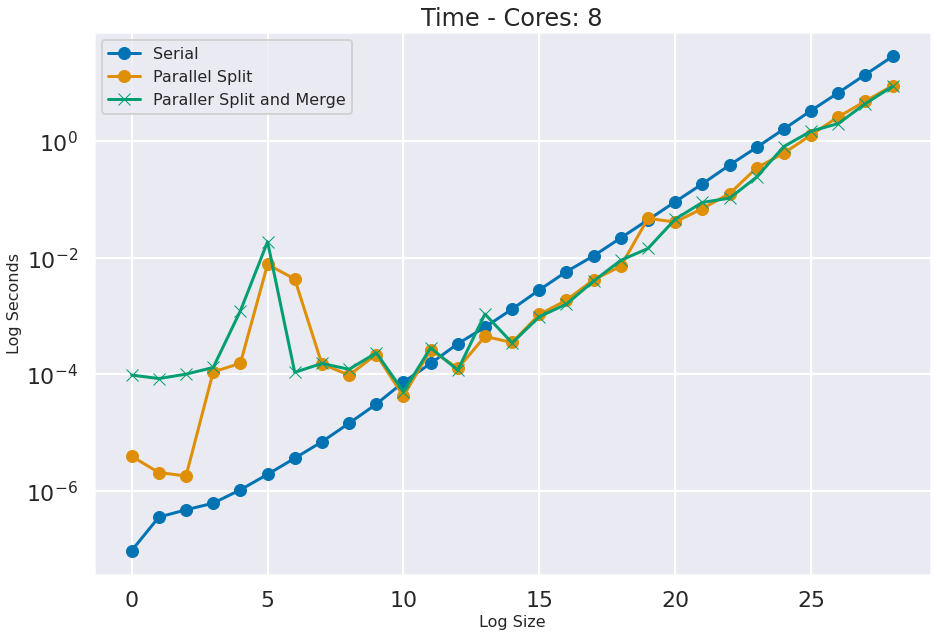

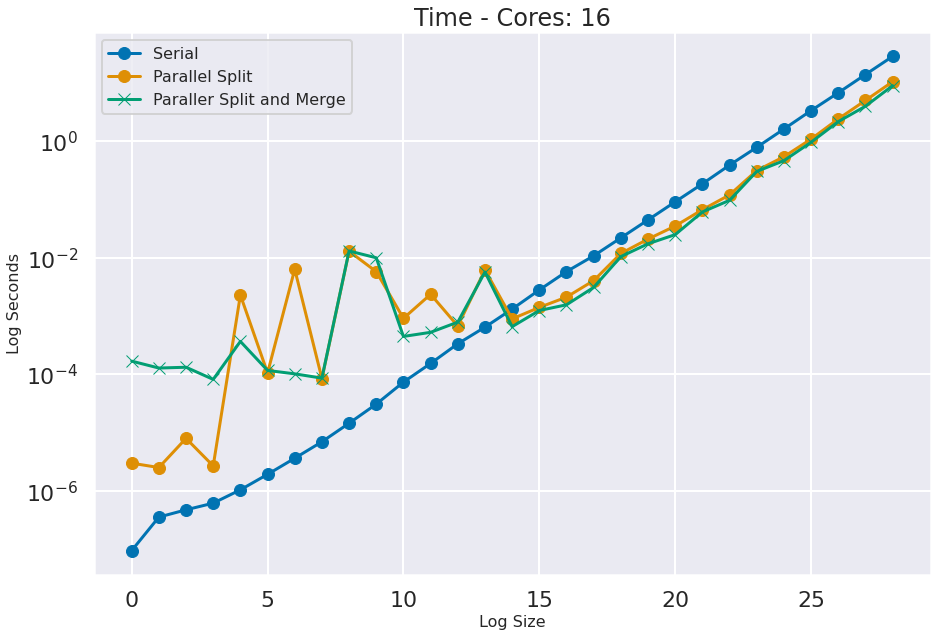

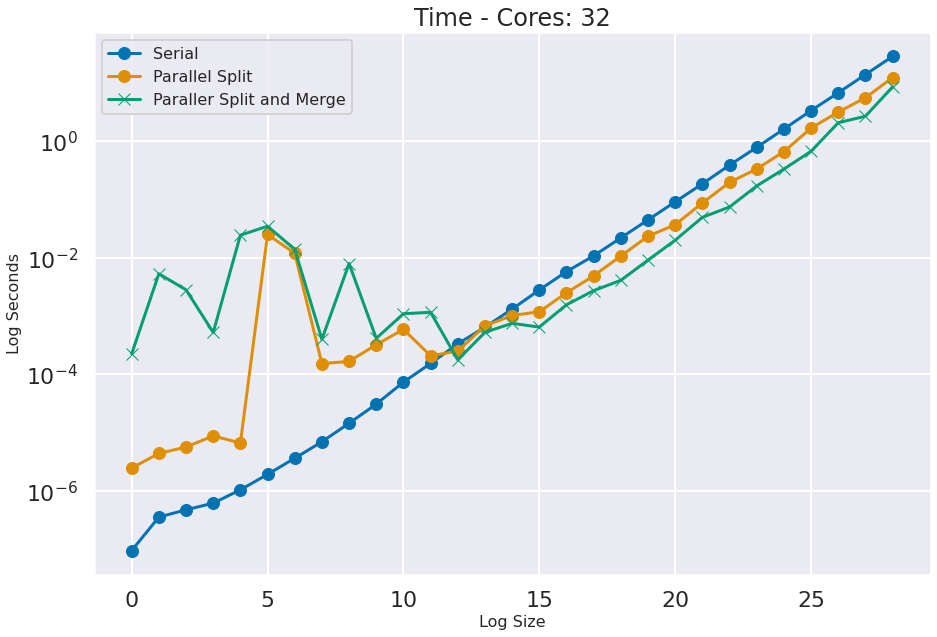

In [14]:
for i in [2,4,8,16,32]:    
    plot_time(i)

## To Latex

In [15]:
print(time_ser[1].to_latex())
print("\n ########################################################## \n")
print(time_p1.to_latex())
print("\n ########################################################## \n")
print(time_p2.to_latex())

\begin{tabular}{lr}
\toprule
{} &             1 \\
\midrule
0  &  9.536743e-08 \\
1  &  3.576279e-07 \\
2  &  4.768372e-07 \\
3  &  6.198883e-07 \\
4  &  1.049042e-06 \\
5  &  1.931190e-06 \\
6  &  3.647804e-06 \\
7  &  6.985664e-06 \\
8  &  1.451969e-05 \\
9  &  3.087521e-05 \\
10 &  7.355213e-05 \\
11 &  1.537085e-04 \\
12 &  3.340244e-04 \\
13 &  6.431103e-04 \\
14 &  1.313353e-03 \\
15 &  2.793169e-03 \\
16 &  5.760145e-03 \\
17 &  1.074040e-02 \\
18 &  2.179577e-02 \\
19 &  4.433482e-02 \\
20 &  9.046867e-02 \\
21 &  1.839343e-01 \\
22 &  3.850481e-01 \\
23 &  7.760364e-01 \\
24 &  1.597620e+00 \\
25 &  3.310150e+00 \\
26 &  6.682985e+00 \\
27 &  1.373232e+01 \\
28 &  2.808158e+01 \\
\bottomrule
\end{tabular}


 ########################################################## 

\begin{tabular}{lrrrrr}
\toprule
{} &         2  &         4  &        8  &         16 &         32 \\
\midrule
0  &   0.000002 &   0.000003 &  0.000004 &   0.000003 &   0.000002 \\
1  &   0.000007 &   0.000002 &

In [16]:
print(speedup_p1.to_latex())
print("\n ########################################################## \n")
print(speedup_p2.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &        2  &        4  &        8  &        16 &        32 \\
\midrule
0  &  0.042105 &  0.029412 &  0.024242 &  0.031746 &  0.038462 \\
1  &  0.049505 &  0.189873 &  0.172414 &  0.141509 &  0.081081 \\
2  &  0.006433 &  0.003418 &  0.263158 &  0.059702 &  0.084034 \\
3  &  0.104000 &  0.076246 &  0.005637 &  0.230088 &  0.070270 \\
4  &  0.132530 &  0.010190 &  0.006786 &  0.000459 &  0.157706 \\
5  &  0.242515 &  0.269103 &  0.000252 &  0.018289 &  0.000077 \\
6  &  0.056835 &  0.022517 &  0.000849 &  0.000577 &  0.000308 \\
7  &  0.620763 &  0.000064 &  0.046508 &  0.082373 &  0.045731 \\
8  &  0.974400 &  0.000337 &  0.149926 &  0.001129 &  0.087062 \\
9  &  1.081872 &  1.272102 &  0.141206 &  0.005366 &  0.096040 \\
10 &  0.502934 &  1.986477 &  1.741954 &  0.080711 &  0.124762 \\
11 &  0.004272 &  0.932456 &  0.577378 &  0.065341 &  0.740014 \\
12 &  0.009668 &  2.492883 &  2.647892 &  0.496333 &  1.333651 \\
13 &  0.009831 &  2.418543 &  1.44

In [17]:
print(efficiency_p1.to_latex())
print("\n ########################################################## \n")
print(efficiency_p2.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &        2  &        4  &        8  &        16 &        32 \\
\midrule
0  &  0.021053 &  0.007353 &  0.003030 &  0.001984 &  0.001202 \\
1  &  0.024752 &  0.047468 &  0.021552 &  0.008844 &  0.002534 \\
2  &  0.003216 &  0.000854 &  0.032895 &  0.003731 &  0.002626 \\
3  &  0.052000 &  0.019062 &  0.000705 &  0.014381 &  0.002196 \\
4  &  0.066265 &  0.002547 &  0.000848 &  0.000029 &  0.004928 \\
5  &  0.121257 &  0.067276 &  0.000032 &  0.001143 &  0.000002 \\
6  &  0.028418 &  0.005629 &  0.000106 &  0.000036 &  0.000010 \\
7  &  0.310381 &  0.000016 &  0.005813 &  0.005148 &  0.001429 \\
8  &  0.487200 &  0.000084 &  0.018741 &  0.000071 &  0.002721 \\
9  &  0.540936 &  0.318026 &  0.017651 &  0.000335 &  0.003001 \\
10 &  0.251467 &  0.496619 &  0.217744 &  0.005044 &  0.003899 \\
11 &  0.002136 &  0.233114 &  0.072172 &  0.004084 &  0.023125 \\
12 &  0.004834 &  0.623221 &  0.330986 &  0.031021 &  0.041677 \\
13 &  0.004916 &  0.604636 &  0.18